# 数据读取

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
family2014 = pd.read_csv('数据/居民出行数据/2014/family_2014.csv',dtype=str)
travel2014 = pd.read_csv('数据/居民出行数据/2014/midtable_2014.csv',dtype=str)
familymember_2014 = pd.read_csv('数据/居民出行数据/2014/family_member_2014.csv',dtype=str)

In [3]:
family2023 = pd.read_csv('数据/居民出行数据/2023/family_total_33169.csv',dtype=str)
travel2023 = pd.read_csv('数据/居民出行数据/2023/midtable_total_33169.csv',dtype=str)
familymember_2023 = pd.read_csv('数据/居民出行数据/2023/familymember_total_33169.csv',dtype=str)

In [4]:
family_cluster = pd.read_csv('数据/family_cluster.csv',dtype=str)

## 家庭变量筛选

In [5]:
family2023[['家庭成员数量']].value_counts()

家庭成员数量
2         16027
3          9865
1          4120
4          2390
5           699
6            66
7             2
Name: count, dtype: int64

In [6]:
## 家庭连续型变量
family2023[['家庭成员数量','家庭工作人口数','机动车数量','脚踏自行车数量','电动自行车数量','摩托车数量','老年代步车数量']]

,家庭成员数量,家庭工作人口数,机动车数量,脚踏自行车数量,电动自行车数量,摩托车数量,老年代步车数量
0,3,2,1,3,0,0,0
1,2,2,1,1,0,0,0
2,2,2,1,0,1,0,0
3,3,2,1,1,1,0,0
4,2,2,1,1,2,0,0
...,...,...,...,...,...,...,...
33164,1,0,0,1,0,0,0
33165,3,1,0,2,1,0,0
33166,3,2,1,1,1,0,0
33167,3,2,1,1,1,0,0


In [7]:
have_student_family = familymember_2023[familymember_2023['职业'] == '14'].drop_duplicates(['家庭编号'])[['家庭编号']]
have_student_family['have_student'] = 1

In [8]:
family2023 = pd.merge(family2023, have_student_family, on='家庭编号', how='left').fillna({'have_student':0})

In [9]:
## 家庭离散型变量
family2023[['have_student','家庭年收入']]

,have_student,家庭年收入
0,0.0,E
1,0.0,C
2,0.0,D
3,1.0,G
4,0.0,B
...,...,...
33164,0.0,B
33165,0.0,C
33166,1.0,D
33167,0.0,E


In [10]:
family2023['家庭年收入'].isna().sum()

0

## 个人变量筛选

In [11]:
familymember_2023['age'] = 2023 - familymember_2023['出生年份'].astype(int)
familymember_2023['age_group'] = pd.cut(familymember_2023['age'], bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], right=False, labels=['0-5','6-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50','51-55','56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96-100'])

In [12]:
familymember_2023['age'].max() , familymember_2023['age'].min()

(123, 0)

In [13]:
familymember_2023['age'] = (familymember_2023['age'] - familymember_2023['age'].min()) / (familymember_2023['age'].max() - familymember_2023['age'].min())

In [14]:
## 连续型变量
familymember_2023[['age']]

,age
0,0.349593
1,0.731707
2,0.479675
3,0.585366
4,0.097561
...,...
79223,0.373984
79224,0.284553
79225,0.146341
79226,0.284553


In [15]:
(familymember_2023[familymember_2023['关系']=='0']['age'] * 123).describe()

count    33053.000000
mean        49.398693
std         14.306649
min          2.000000
25%         38.000000
50%         48.000000
75%         61.000000
max        120.000000
Name: age, dtype: float64

In [16]:
familymember_2023.loc[familymember_2023['最高学历'].isna(),'最高学历'] = familymember_2023.loc[familymember_2023['最高学历'].isna(),'教育阶段']

In [17]:
## 离散型变量,这里的关系有点不太对，有的户主很小
familymember_2023[['性别','是否有驾照','关系','最高学历','职业']]

,性别,是否有驾照,关系,最高学历,职业
0,2,0,0,6,11
1,2,0,2,2,15
2,2,0,0,6,15
3,2,0,0,3,15
4,1,NaN,9,2,14
...,...,...,...,...,...
79223,2,0,0,6,3
79224,1,0,0,6,2
79225,1,0,0,6,3
79226,1,1,0,6,8


In [18]:
familymember_2023['是否有驾照'] = familymember_2023['是否有驾照'].fillna('0')

## 图编码

In [19]:
import numpy as np

In [20]:
familymember_2023 = pd.merge(familymember_2023, familymember_2023.groupby('家庭编号').size().rename('家庭成员数量').reset_index())

In [21]:
adj_list = []
node_feature_list = []
edge_feature_list = []

In [22]:
atom_types = ['Male_Child', 'Female_Child', 'Male_Adult', 'Female_Adult', 'Male_Elder', 'Female_Elder']
family_relation_types = ['SPOUSE', 'PARENT_CHILD',  'GRANDPARENT_GRANDCHILD', 'SIBLING', 'EXTENDED_FAMILY']

In [23]:
familymember_2023['real_age'] = familymember_2023['age'] * 123

In [24]:
def judge_relation_type(relation):
    if relation in [set(['0','0']),set(['17','17']),set(['0','17']),set(['1', '2']),set(['13', '14']),set(['15', '16'])]:
        return [1,0,0,0,0]  # SPOUSE
    elif relation in [set(['1', '0']), set(['2', '0']), set(['1', '17']), set(['2', '17']), set(['0', '5']), set(['0', '6']), set(['17', '5']), set(['17', '6']), set(['13', '1']), set(['14', '1']), set(['15', '2']), set(['16', '2']),  set(['1', '7']), set(['1', '8']), set(['2', '7']), set(['2', '8'])]:
        return [0,1,0,0,0]  # PARENT_CHILD
    elif relation in [set(['0', '13']), set(['0', '14']),set(['0', '15']), set(['0', '16']),set(['17', '13']), set(['17', '14']),set(['17', '15']), set(['17', '16']),set(['1', '5']), set(['1', '6']), set(['2', '5']), set(['2', '6']), set(['0', '9']), set(['0', '10']), set(['17', '9']), set(['17', '10']),set(['7', '13']), set(['7', '14']),set(['7', '15']), set(['7', '16']),set(['8', '13']), set(['8', '14']),set(['8', '15']), set(['8', '16'])]:
        return [0,0,1,0,0]  # GRANDPARENT_GRANDCHILD
    elif relation in [set(['0', '7']), set(['0', '8']), set(['17', '7']), set(['17', '8']), set(['5', '6']), set(['9', '10']), set(['7', '8']),set(['7', '7']),set(['8', '8']), set(['5', '5']), set(['6', '6']),set(['9', '9']),set(['10', '10'])]:
        return [0,0,0,1,0]  # SIBLING
    else:
        return [0,0,0,0,1]  # EXTENDED_FAMILY

In [25]:
def judge_node_type(row):
    if row['性别'] == '1' and row['real_age'] < 18:
        return [1, 0, 0, 0, 0, 0]
    elif row['性别'] == '2' and row['real_age'] < 18:
        return [0, 1, 0, 0, 0, 0]
    elif row['性别'] == '1' and 18 <= row['real_age'] < 60:
        return [0, 0, 1, 0, 0, 0]
    elif row['性别'] == '2' and 18 <= row['real_age'] < 60:
        return [0, 0, 0, 1, 0, 0]
    elif row['性别'] == '1' and row['real_age'] >= 60:
        return [0, 0, 0, 0, 1, 0]
    elif row['性别'] == '2' and row['real_age'] >= 60:
        return [0, 0, 0, 0, 0, 1]
    else:
        return None

In [26]:
familymember_2023['node_type'] = familymember_2023.apply(judge_node_type, axis=1)

In [27]:
from itertools import combinations
from tqdm import tqdm

In [28]:
pair_wise_list = []

In [29]:
for i in tqdm(family2023['家庭编号'].unique()):
    tmp = familymember_2023[familymember_2023['家庭编号'] == i]
    pair_wise_list.extend(list(combinations(tmp['关系'].values,2)))

100%|██████████| 33169/33169 [02:21<00:00, 233.84it/s]


In [30]:
len(set(pair_wise_list))

171

In [31]:
total_relation = list(set(pair_wise_list))

In [32]:
total_relation = [set(i) for i in total_relation]

In [33]:
total_judge_result = pd.DataFrame([str(i) for i in total_relation],columns=['relation_pair'])

In [34]:
total_judge_result = pd.concat([total_judge_result, pd.DataFrame([str(judge_relation_type(i)) for i in total_relation],columns=['relation_type'])], axis=1)

In [35]:
total_judge_result

,relation_pair,relation_type
0,"{'13', '5'}","[0, 0, 0, 0, 1]"
1,"{'0', '5'}","[0, 1, 0, 0, 0]"
2,"{'14', '7'}","[0, 0, 1, 0, 0]"
3,{'9'},"[0, 0, 0, 1, 0]"
4,"{'5', '7'}","[0, 0, 0, 0, 1]"
...,...,...
166,"{'12', '0'}","[0, 0, 0, 0, 1]"
167,"{'9', '1'}","[0, 0, 0, 0, 1]"
168,{'1'},"[0, 0, 0, 0, 1]"
169,"{'2', '8'}","[0, 1, 0, 0, 0]"


In [36]:
adj_list = []
node_feature_list = []
edge_feature_list = []

In [37]:
for i in tqdm(familymember_2023['家庭编号'].unique()):
    tmp = familymember_2023[familymember_2023['家庭编号'] == i]
    tmp = tmp.sort_values('age', ascending=False)
    adj_matrix = np.zeros((8, 8))
    node_feature = np.zeros((8, len(atom_types)))
    edge_feature = np.zeros((8, 8, len(family_relation_types)))
    node_feature[:len(tmp), :] = np.array(tmp['node_type'].tolist())
    ## 邻接矩阵构建
    n = len(tmp)  # 矩阵大小
    A = np.ones((n, n)) - np.eye(n)
    adj_matrix[:n, :n] = A
    ## 边关系的构建
    for p_i in range(n):
        for p_j in range(n-1):
            if p_i == p_j:
                continue
            relation = set([tmp.iloc[p_i]['关系'], tmp.iloc[p_j]['关系']])
            relation_type = judge_relation_type(relation)
            edge_feature[p_i, p_j, :] = relation_type
            edge_feature[p_j, p_i, :] = relation_type
    adj_list.append(adj_matrix)
    edge_feature_list.append(edge_feature)
    node_feature_list.append(node_feature)

100%|██████████| 33169/33169 [02:52<00:00, 192.67it/s]


In [38]:
np.save('数据/family_adj.npy', np.array(adj_list))
np.save('数据/familymember_relationship.npy', np.array(edge_feature_list))
np.save('数据/familymember_type.npy', np.array(node_feature_list))


## 变量编码

In [19]:
from population_data_process import *

/home/cranehh/anaconda3/envs/DiT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
## 家庭的变量编码
test = PopulationDataEncoder()

In [21]:
family2023 = pd.merge(family2023,family_cluster[['家庭编号','cluster']], on='家庭编号', how='left')

In [22]:
# 2. 拟合数据 (需要你的实际数据)
test.fit_family_data(family2023)
test.fit_person_data(familymember_2023)



In [23]:
encode_family_data = test.encode_family(family2023)
encode_member_data = test.encode_person(familymember_2023)

In [24]:
encode_member_data['person_age']

array([-0.30081301,  0.46341463, -0.04065041, ..., -0.70731707,
       -0.43089431, -0.51219512])

In [25]:
encode_family_data

{'family_家庭成员数量': array([ 0.2304334, -0.1465826, -0.1465826, ...,  0.2304334,  0.2304334,
        -0.1465826]),
 'family_家庭工作人口数': array([0.27245345, 0.27245345, 0.27245345, ..., 0.27245345, 0.27245345,
        0.27245345]),
 'family_机动车数量': array([0.3120489, 0.3120489, 0.3120489, ..., 0.3120489, 0.3120489,
        0.3120489]),
 'family_脚踏自行车数量': array([ 1.        ,  0.24795427, -0.25781999, ...,  0.24795427,
         0.24795427, -0.25781999]),
 'family_电动自行车数量': array([-0.4259439 , -0.4259439 ,  0.09011459, ...,  0.09011459,
         0.09011459, -0.4259439 ]),
 'family_摩托车数量': array([-0.04989937, -0.04989937, -0.04989937, ..., -0.04989937,
        -0.04989937, -0.04989937]),
 'family_老年代步车数量': array([-0.11318683, -0.11318683, -0.11318683, ..., -0.11318683,
        -0.11318683, -0.11318683]),
 'family_have_student': array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]]),
 'family_家庭年收入': array([[0., 0., 0., ..., 0., 0., 

In [26]:
# 3. 创建数据集
dataset_family, dataset_member = create_population_dataset(family2023, familymember_2023, test)

In [27]:
np.save('数据/family_sample.npy',dataset_family.numpy())
np.save('数据/family_member_sample.npy',dataset_member.numpy())


# 网络构建

In [144]:
import torch
import numpy as np

dataset_family = torch.from_numpy(np.load('数据/family_sample.npy'))
dataset_member = torch.from_numpy(np.load('数据/family_member_sample.npy'))

family_adj = np.load('数据/family_adj.npy')
familymember_relationship = np.load('数据/familymember_relationship.npy')
familymember_type = np.load('数据/familymember_type.npy')

In [145]:
dataset_family = dataset_family.to('cuda')
dataset_member = dataset_member.to('cuda')

In [146]:
from population_DiT import PopulationDiT

In [147]:
test = PopulationDiT().to('cuda')

In [148]:
t = torch.randint(0, 10, (100,), device='cuda')
family_final_result, person_final_result, relation_graph = test(dataset_family[:100], dataset_member[:100],t)

/mnt/d/OneDrive/Python scripts for big data/2025_05博士论文第一章-合成人口/GraphVAE-master/graph_vae/graph_datastructure.py:592: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/IndexingUtils.h:27.)
  adj_mat[msk.triu()] = adj_mat_logits.contiguous().view(-1)
/mnt/d/OneDrive/Python scripts for big data/2025_05博士论文第一章-合成人口/GraphVAE-master/graph_vae/graph_datastructure.py:594: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/IndexingUtils.h:27.)
  edge_attribute_tensor[msk[:, None, :, :].triu(diagonal=1).repeat(1,CHEM_DETAILS.num_bond_types, 1,1)] = edge_atr_logits.contiguous().view(-1)


In [159]:
person_mask = (torch.sum(dataset_member[:100,:,:],dim=-1)!=0)

In [149]:
source_data_family = dataset_family[:100]
source_data_member = dataset_member[:100]
source_data_adj = torch.from_numpy(family_adj[:100]).to('cuda')
source_data_edge = torch.from_numpy(familymember_relationship[:100]).to('cuda')
source_data_node = torch.from_numpy(familymember_type[:100]).to('cuda')

In [150]:
valid_person = torch.sum(source_data_node, dim=-1) != 0
num_nodes_active = torch.sum(valid_person, dim=-1, dtype=torch.float32)

In [151]:
a_norm_one = torch.sum(source_data_adj, dim=[1,2], dtype=torch.float32)

In [152]:
valid_edge = torch.sum(source_data_edge, dim=-1) != 0

In [153]:
import torch.nn.functional as F

In [154]:
family_continus_loss = F.mse_loss(
                            family_final_result[:, :7], 
                            source_data_family[:, :7],
                            reduction = "none"
                        )

family_continus_loss = torch.sum(family_continus_loss, dim=-1)

# 学生状态分类损失
family_student_loss = F.cross_entropy(
    family_final_result[:, 7:7+2],
    source_data_family[:, 7:7+2].argmax(dim=-1),
    reduction = "none"
)


# 收入类别分类损失  
family_income_loss = F.cross_entropy(
    family_final_result[:, 7+2:7+12],
    source_data_family[:, 7+2:7+12].argmax(dim=-1),
    reduction = "none"
)


In [ ]:


##学生损失
person_continus_loss = F.mse_loss(
    person_final_result[:,:, :1], 
    source_data_member[:,:, :1],
    reduction = "none"
).mean(dim=[1, 2])

## 离散类别状态损失
person_gender_loss = F.cross_entropy(
    person_final_result[:,:, 1:1+2].transpose(1, 2),
    source_data_member[:,:, 1:1+2].argmax(dim=-1),
    reduction = "none"
).mean(dim=-1)

person_license_loss = F.cross_entropy(
    person_final_result[:,:, 1+2:1+4].transpose(1, 2),
    source_data_member[:,:, 1+2:1+4].argmax(dim=-1),
    reduction = "none"
).mean(dim=-1)


person_relation_loss = F.cross_entropy(
    person_final_result[:,:, 1+4:1+20].transpose(1, 2),
    source_data_member[:,:, 1+4:1+20].argmax(dim=-1),
    reduction = "none"
).mean(dim=-1)

person_education_loss = F.cross_entropy(
    person_final_result[:,:, 1+20:1+29].transpose(1, 2),
    source_data_member[:,:, 1+20:1+29].argmax(dim=-1),
    reduction = "none"
).mean(dim=-1)

person_occupation_loss = F.cross_entropy(
    person_final_result[:,:, 1+29:1+49].transpose(1, 2),
    source_data_member[:,:, 1+29:1+49].argmax(dim=-1),
    reduction = "none"
).mean(dim=-1)

In [154]:
def compute_adjacency_loss(decoder_adj_logits, true_adj_matrix):
    """
    邻接矩阵二元交叉熵损失 - 基于GraphVAE实现
    
    Args:
        decoder_adj_logits: [batch_size, max_family_size, max_family_size] 预测的邻接矩阵logits
        true_adj_matrix: [batch_size, max_family_size, max_family_size] 真实邻接矩阵
        family_mask: [batch_size, max_family_size] 家庭成员存在掩码
    """
    batch_size, max_nodes, _ = decoder_adj_logits.shape
    
    # 展平为向量形式
    adj_logits_flat = decoder_adj_logits.view(-1)  # [B, N*N]
    adj_truth_flat = true_adj_matrix.view(-1)      # [B, N*N] 
    
    # 计算二元交叉熵损失
    bce_loss = F.binary_cross_entropy_with_logits(
        adj_logits_flat, adj_truth_flat, reduction='none'
    )
    
    loss1 = torch.sum(bce_loss.view(batch_size, -1), dim=1) / ((max_nodes)**2)
    
    return loss1


#### 3.1.2 节点类型重建损失

def compute_node_type_loss(decoder_node_logits, true_node_types, node_mask):
    """
    节点类型交叉熵损失
    
    Args:
        decoder_node_logits: [batch_size, max_family_size, num_node_types] 预测的节点类型
        true_node_types: [batch_size, max_family_size] 真实节点类型索引
        family_mask: [batch_size, max_family_size] 家庭成员存在掩码
    """
    batch_size, max_nodes, num_classes = decoder_node_logits.shape
    
    node_idx = torch.arange(batch_size, device=decoder_node_logits.device).repeat_interleave(max_nodes)
    graph_idx_associated_with_considered_node = node_idx[node_mask.view(-1)]
    num_nodes_active = torch.sum(node_mask, dim = -1, dtype=torch.float32)

    # 只对存在的节点计算损失
    active_node_logits = decoder_node_logits[node_mask]  # [num_active_nodes, num_classes]
    active_node_types = true_node_types[node_mask].argmax(dim=-1)       # [num_active_nodes]

    # 交叉熵损失
    node_loss = F.cross_entropy(active_node_logits, active_node_types,  reduction='none')
    node_loss = (torch.scatter_add(torch.zeros(batch_size, dtype=node_loss.dtype, device=node_loss.device), 0, graph_idx_associated_with_considered_node, node_loss)
                    / num_nodes_active)
    
    return node_loss


#### 3.1.3 边类型重建损失

def compute_edge_type_loss(decoder_edge_logits, true_edge_types, a_norm_one, valid_edge):
    """
    边类型交叉熵损失
    
    Args:
        decoder_edge_logits: [batch_size, max_family_size, max_family_size, num_edge_types]
        true_edge_types: [batch_size, max_family_size, max_family_size] 真实边类型索引
        true_adj_matrix: [batch_size, max_family_size, max_family_size] 邻接矩阵
        family_mask: [batch_size, max_family_size] 家庭成员存在掩码
    """
    batch_size, max_nodes, _, _ = decoder_edge_logits.shape

    edge_mask = valid_edge.view(-1)  # [bvv]
    edge_idx = torch.arange(batch_size, device=decoder_edge_logits.device).repeat_interleave(max_nodes*max_nodes)
    graph_idx_associated_with_considered_edge = edge_idx[edge_mask]


    # 提取存在边的logits和标签
    active_edge_logits = decoder_edge_logits[valid_edge]  # [num_active_edges, num_edge_types]
    active_edge_types = true_edge_types[valid_edge].argmax(dim=-1)       # [num_active_edges]

    # 交叉熵损失
    edge_loss = F.cross_entropy(active_edge_logits, active_edge_types, reduction='none')
    edge_loss = torch.scatter_add(torch.zeros(batch_size, dtype=edge_loss.dtype, device=edge_loss.device), 0, graph_idx_associated_with_considered_edge, edge_loss)
    edge_loss = edge_loss / (a_norm_one + 1e-6)
    
    return edge_loss

In [155]:
graph_loss_1 = compute_adjacency_loss(relation_graph['adj_matrix'], source_data_adj)

In [156]:
graph_loss_2 = compute_node_type_loss(relation_graph['node_types'],source_data_node,valid_person)

In [157]:
graph_loss_3 = compute_edge_type_loss(relation_graph['edge_types'], source_data_edge, a_norm_one, valid_edge)

In [158]:
final_loss = family_continus_loss + family_student_loss + family_income_loss + \
             person_continus_loss + person_gender_loss + person_license_loss + person_relation_loss + person_education_loss + person_occupation_loss + \
             graph_loss_1 + graph_loss_2 + graph_loss_3

In [ ]:
## 添加mask的损失函数设计
batch_size, max_nodes = person_mask.shape


person_idx = torch.arange(batch_size, device=person_mask.device).repeat_interleave(max_nodes)
graph_idx_associated_with_considered_person = person_idx[person_mask.view(-1)]

##学生损失
person_continus_loss = F.mse_loss(
    person_final_result[:,:, :1][person_mask], 
    source_data_member[:,:, :1][person_mask],
    reduction = "none"
).mean(dim=-1)

person_continus_loss = torch.scatter_add(torch.zeros(batch_size, dtype=person_continus_loss.dtype, device=person_continus_loss.device), 0, graph_idx_associated_with_considered_person, person_continus_loss)

person_gender_loss = F.cross_entropy(
    person_final_result[:,:, 1:1+2][person_mask],
    source_data_member[:,:, 1:1+2][person_mask].argmax(dim=-1),
    reduction = "none"
)

person_gender_loss = torch.scatter_add(torch.zeros(batch_size, dtype=person_gender_loss.dtype, device=person_gender_loss.device), 0, graph_idx_associated_with_considered_person, person_gender_loss)

invalid_indices = ~person_mask
person_invalid_idx = torch.arange(batch_size, device=person_mask.device).repeat_interleave(max_nodes)
graph_idx_associated_with_considered_invalid_person = person_invalid_idx[invalid_indices.view(-1)]

pred_invalid = person_final_result[invalid_indices]
zero_target = torch.zeros_like(pred_invalid)
zero_loss = F.mse_loss(pred_invalid, zero_target, reduction='none').mean(dim=-1)

zero_loss = torch.scatter_add(torch.zeros(batch_size, dtype=zero_loss.dtype, device=zero_loss.device), 0, graph_idx_associated_with_considered_invalid_person, zero_loss)

In [ ]:
## 显示添加成员数量和mask的关系 


# 模型效果测试

## 数据复原过程

In [22]:
from population_DiT import *
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

import argparse
import logging
import os
import numpy as np
from collections import OrderedDict
from copy import deepcopy
from glob import glob
from time import time
from tqdm import tqdm

from losses import compute_total_loss
from dataset import load_population_data, create_dataloader

In [23]:
model_result = load_population_dit_checkpoint("results/007-PopulationDiT/checkpoints/final.pt")

Loading checkpoint from results/007-PopulationDiT/checkpoints/final.pt
Model parameters:
  - Hidden size: 128
  - Depth: 3
  - Num heads: 8
  - Max family size: 8
✅ EMA model loaded successfully
✅ Checkpoint loaded successfully!
  - Epoch: 5000
  - Train steps: 160000


In [24]:
args = model_result['args']

In [25]:
model = model_result['model']

In [26]:
class DiffusionScheduler:
    """扩散调度器"""
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.num_timesteps = num_timesteps
        
        # 创建beta调度
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # 为采样准备的系数
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        
    def add_noise(self, x_start, noise, timesteps):
        """添加噪声到原始数据"""
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[timesteps].reshape(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1, 1)
        
        # 对于成员数据，需要额外处理维度
        if len(x_start.shape) == 3:  # member data: [batch, family_size, features]
            sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.unsqueeze(-1)
            sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.unsqueeze(-1)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    def to(self, device):
        """移动到指定设备"""
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(device)
        return self

In [27]:
print(f"Training Population DiT with {args.model_config}")
    
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 创建实验文件夹

# 加载数据
dataset = load_population_data(args.data_dir)
dataloader = create_dataloader(
    dataset, 
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True
)



model.train()


# 训练变量
train_steps = 0
log_steps = 0
running_loss = 0
start_time = time()

scheduler = DiffusionScheduler(num_timesteps=args.num_timesteps).to(device)

epoch = 0
epoch_loss = 0
epoch_steps = 0

progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")

results_family_list = []
results_member_list = []

raw_data_family_list = []
raw_data_member_list = []

for batch in progress_bar:
    # 将数据移至GPU
    family_data = batch['family'].to(device)
    member_data = batch['member'].to(device)
    adj_data = batch['adj'].to(device)
    edge_data = batch['edge'].to(device)
    node_data = batch['node'].to(device)
    
    # 随机时间步
    t = torch.randint(0, scheduler.num_timesteps, (family_data.shape[0],), device=device)
    
    # 创建噪声
    noise_family = torch.randn_like(family_data)
    noise_member = torch.randn_like(member_data)
    
    # 添加噪声
    x_family_noisy = scheduler.add_noise(family_data, noise_family, t)
    x_member_noisy = scheduler.add_noise(member_data, noise_member, t)
    
    # 前向传播
    pred_family, pred_member, pred_graph = model(x_family_noisy, x_member_noisy, t)

    # 保存结果用于分析
    results_family_list.append(pred_family.detach().cpu().numpy())
    results_member_list.append(pred_member.detach().cpu().numpy())

    raw_data_family_list.append(family_data.detach().cpu().numpy())
    raw_data_member_list.append(member_data.detach().cpu().numpy())
    
    # 计算损失
    loss_dict = compute_total_loss(
        pred_family, family_data,
        pred_member, member_data,
        pred_graph, adj_data, edge_data, node_data,
        weights=args.loss_weights
    )
    
    total_loss = loss_dict['total_loss'].mean()
    

    # 记录损失
    running_loss += total_loss.item()
    epoch_loss += total_loss.item()
    log_steps += 1
    train_steps += 1
    epoch_steps += 1
    
    # 更新进度条
    progress_bar.set_postfix({
        'loss': f'{total_loss.item():.4f}',
        'avg_loss': f'{epoch_loss/epoch_steps:.4f}'
    })
    

Training Population DiT with base
Using device: cuda


Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]/mnt/d/OneDrive/Python scripts for big data/2025_05博士论文第一章-合成人口/GraphVAE-master/graph_vae/graph_datastructure.py:592: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/IndexingUtils.h:27.)
  adj_mat[msk.triu()] = adj_mat_logits.contiguous().view(-1)
/mnt/d/OneDrive/Python scripts for big data/2025_05博士论文第一章-合成人口/GraphVAE-master/graph_vae/graph_datastructure.py:594: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/IndexingUtils.h:27.)
  edge_attribute_tensor[msk[:, None, :, :].triu(diagonal=1).repeat(1,CHEM_DETAILS.num_bond_types, 1,1)] = edge_atr_logits.contiguous().view(-1)
Epoch 0: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s, loss=11.5542, avg_l

In [28]:
import pandas as pd


In [29]:
results_family_df = pd.DataFrame(np.concatenate(results_family_list, axis=0))

In [30]:
raw_family_df = pd.DataFrame(np.concatenate(raw_data_family_list, axis=0))

In [31]:
results_person_df = pd.DataFrame(np.concatenate(results_member_list, axis=0).reshape(-1, 50))
raw_person_df = pd.DataFrame(np.concatenate(raw_data_member_list, axis=0).reshape(-1, 50))

In [32]:
## TODO: 个人的需要增加一个mask的判断项

In [33]:
results_person_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.020901,0.973380,2.661981e-02,1.000000,1.585849e-09,1.000000e+00,2.215693e-10,1.756546e-10,3.340383e-11,1.725359e-11,7.107186e-13,4.507706e-12,2.107290e-12,3.143311e-12,1.082884e-08,1.367930e-09,5.371149e-11,2.764477e-11,9.518886e-13,2.367120e-10,9.070944e-11,0.999946,9.362376e-08,4.331585e-05,8.145367e-08,5.078685e-08,1.062261e-05,3.687009e-09,4.096449e-09,2.442983e-08,9.999601e-01,2.483924e-12,2.285977e-12,9.722886e-12,1.048675e-11,1.107022e-10,3.990511e-05,2.598060e-12,2.183820e-09,2.090115e-11,2.860477e-13,8.235353e-12,1.104065e-12,1.988139e-11,1.278414e-12,5.857768e-12,3.390334e-11,2.593076e-11,4.768658e-12,3.692844e-11
1,0.015656,0.612412,3.875878e-01,0.999871,1.294418e-04,1.000000e+00,2.022781e-12,6.725869e-13,6.326553e-14,3.976379e-14,6.484946e-16,9.482707e-15,4.146555e-14,4.240122e-14,4.899826e-10,3.962747e-12,9.432729e-13,4.130667e-13,6.011452e-16,5.534593e-14,1.371877e-14,0.998096,1.160625e-05,6.586096e-04,1.171229e-03,1.724117e-06,6.119743e-05,5.184079e-09,5.583430e-09,1.801522e-08,8.155411e-02,5.375691e-13,6.842030e-13,3.652684e-12,1.626441e-11,2.312899e-12,9.184459e-01,1.448182e-11,2.073344e-09,5.308718e-12,9.838253e-13,5.507500e-12,3.514274e-12,2.241638e-10,4.579210e-13,3.722299e-12,2.407938e-10,6.365788e-11,3.664443e-12,1.607450e-10
2,-0.091887,0.999996,4.378999e-06,1.000000,5.242500e-09,1.000000e+00,2.475046e-12,2.801080e-10,8.642589e-11,7.074217e-12,1.440914e-12,3.999321e-13,1.132234e-12,1.201738e-12,3.953363e-12,2.457904e-12,4.713901e-12,1.631432e-11,1.702452e-12,4.016694e-11,7.609363e-10,1.000000,1.514567e-07,2.097166e-08,1.018048e-08,4.524492e-09,1.494260e-09,1.208555e-09,4.662109e-09,3.464222e-09,1.000000e+00,7.968431e-14,3.379129e-13,4.686251e-13,4.704295e-14,4.533492e-10,8.362368e-14,7.561372e-14,4.178532e-12,3.192590e-13,1.234832e-13,1.695937e-13,4.861396e-15,2.129198e-14,4.172007e-13,1.196643e-14,1.162321e-12,4.949802e-12,1.596060e-13,8.292296e-13
3,0.099738,0.999995,5.422235e-06,0.999934,6.621095e-05,4.148158e-08,5.356392e-09,8.410921e-13,6.244356e-12,1.480316e-12,4.764534e-14,6.903959e-14,2.516522e-12,2.385970e-12,1.000000e+00,3.000369e-12,4.909967e-14,4.724497e-15,1.584002e-13,2.950860e-14,8.706694e-13,0.000022,6.529034e-05,2.231543e-07,9.999111e-01,7.888405e-08,8.268842e-07,5.602819e-10,5.774776e-10,7.316226e-10,4.912958e-13,1.890228e-19,2.737923e-20,2.611989e-18,6.440395e-17,1.436662e-18,1.000000e+00,7.377329e-18,9.745837e-15,4.881216e-18,8.041014e-18,2.832282e-18,6.293617e-20,4.766612e-19,2.595701e-17,1.792406e-19,4.802685e-16,1.061071e-18,1.214377e-18,8.958195e-17
4,-0.073817,0.999911,8.933120e-05,1.000000,7.337466e-09,1.000000e+00,1.720747e-12,3.282867e-11,3.038368e-11,3.118112e-12,1.009196e-13,1.681321e-13,1.311036e-13,1.295335e-13,5.200386e-12,5.280184e-12,2.065425e-11,1.441691e-10,1.469972e-13,2.225939e-11,3.763084e-12,1.000000,1.841306e-08,5.300083e-08,5.571059e-10,2.064132e-09,2.890946e-09,3.351292e-09,1.825586e-09,6.746603e-10,1.000000e+00,5.277423e-13,4.804552e-13,1.837299e-13,4.123991e-13,6.332878e-11,6.048195e-13,4.034709e-14,1.774967e-12,1.555190e-13,3.434017e-14,2.765846e-13,2.621622e-14,9.697007e-13,3.197075e-13,2.795141e-13,1.718530e-12,6.600460e-13,1.168879e-13,3.583765e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,-0.033524,1.000000,6.999843e-09,1.000000,5.314938e-10,1.000000e+00,6.217236e-12,9.298648e-13,4.529211e-11,1.124792e-11,4.684712e-14,4.166051e-13,1.271672e-13,1.077387e-13,1.271268e-11,1.035951e-12,8.452051e-11,6.020415e-12,1.474989e-12,1.272033e-11,1.183735e-11,1.000000,1.001540e-08,4.816628e-09,1.746198e-09,8.582273e-10,8.243580e-10,1.097987e-09,1.022088e-09,1.275788e-09,1.000000e+00,2.836939e-13,5.032967e-13,9.270556e-14,6.350894e-13,1.655178e-11,3.767520e-13,

In [34]:
raw_person_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.121951,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.121951,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.821138,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262140,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262141,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262142,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
results_family_df['have_student'] = results_family_df[[7,8]].values.argmax(axis=1)

In [36]:
raw_family_df['have_student'] = raw_family_df[[7,8]].values.argmax(axis=1)

In [37]:
results_family_df['income'] = results_family_df.iloc[:,9:].values.argmax(axis=1)
raw_family_df['income'] = raw_family_df.iloc[:,9:].values.argmax(axis=1)

In [38]:
results_family_df = results_family_df[[0,1,2,3,4,5,6,'have_student','income']]

In [39]:
results_family_df.columns = ['family_家庭成员数量','family_家庭工作人口数','family_机动车数量','family_脚踏自行车数量','family_电动自行车数量','family_摩托车数量','family_老年代步车数量','have_student','income']

In [40]:
raw_family_df = raw_family_df[[0,1,2,3,4,5,6,'have_student','income']]

In [41]:
raw_family_df.columns = ['family_家庭成员数量','family_家庭工作人口数','family_机动车数量','family_脚踏自行车数量','family_电动自行车数量','family_摩托车数量','family_老年代步车数量','have_student','income']

In [42]:
raw_person_df['is_real'] = (raw_person_df.sum(axis=1) != 0)

In [43]:
results_person_df['is_real'] = raw_person_df['is_real']

In [44]:
raw_person_df = raw_person_df[raw_person_df['is_real'] == True]
results_person_df = results_person_df[results_person_df['is_real'] == True]

In [45]:
results_person_df['gender'] = results_person_df[[1,2]].values.argmax(axis=1)
results_person_df['license'] = results_person_df[[3,4]].values.argmax(axis=1)
results_person_df['relation'] = results_person_df.iloc[:,5:21].values.argmax(axis=1)
results_person_df['education'] = results_person_df.iloc[:,21:30].values.argmax(axis=1)
results_person_df['occupation'] = results_person_df.iloc[:,30:50].values.argmax(axis=1)

raw_person_df['gender'] = raw_person_df[[1,2]].values.argmax(axis=1)
raw_person_df['license'] = raw_person_df[[3,4]].values.argmax(axis=1)
raw_person_df['relation'] = raw_person_df.iloc[:,5:21].values.argmax(axis=1)
raw_person_df['education'] = raw_person_df.iloc[:,21:30].values.argmax(axis=1)
raw_person_df['occupation'] = raw_person_df.iloc[:,30:50].values.argmax(axis=1)

/tmp/ipykernel_1892547/1047013329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_person_df['gender'] = results_person_df[[1,2]].values.argmax(axis=1)
/tmp/ipykernel_1892547/1047013329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_person_df['license'] = results_person_df[[3,4]].values.argmax(axis=1)
/tmp/ipykernel_1892547/1047013329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [46]:
results_person_df = results_person_df[[0,'gender','license','relation','education','occupation']]
results_person_df.columns = ['age','gender','license','relation','education','occupation']
raw_person_df = raw_person_df[[0,'gender','license','relation','education','occupation']]
raw_person_df.columns = ['age','gender','license','relation','education','occupation']

In [48]:
decode_results_family = test.decode_family_continuous(results_family_df)
for col in decode_results_family.keys():
    results_family_df[f'family_{col}'] = decode_results_family[col]

In [49]:
decode_raw_family = test.decode_family_continuous(raw_family_df)
for col in decode_raw_family.keys():
    raw_family_df[f'family_{col}'] = decode_raw_family[col]

In [51]:
results_person_df['age'] = test.decode_person_continuous(results_person_df['age'])['age_actual']
raw_person_df['age'] = test.decode_person_continuous(raw_person_df['age'])['age_actual']

## 精度比较1：错误率比较

### 家庭的

0.529998779296875


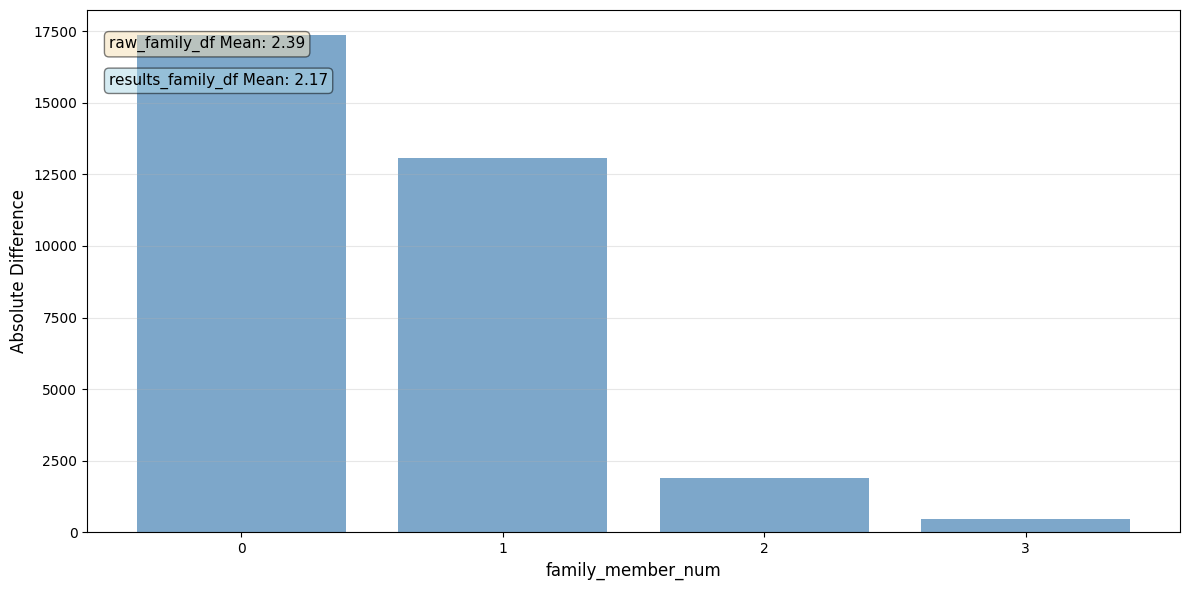

In [91]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 计算绝对差异
differences = abs(raw_family_df['family_家庭成员数量'] - results_family_df['family_家庭成员数量'])
print((differences==0).sum()/len(differences))
differences_stas = differences.value_counts()
# 计算两个数据源的均值
raw_mean = raw_family_df['family_家庭成员数量'].mean()
results_mean = results_family_df['family_家庭成员数量'].mean()

# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(differences_stas.index, differences_stas.values, alpha=0.7, color='steelblue')
plt.xticks(differences_stas.index)
plt.xlabel('family_member_num', fontsize=12)
plt.ylabel('Absolute Difference', fontsize=12)
# plt.title('家庭成员数量绝对差异分布', fontsize=14, fontweight='bold')

# 在空白处添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

0.476776123046875


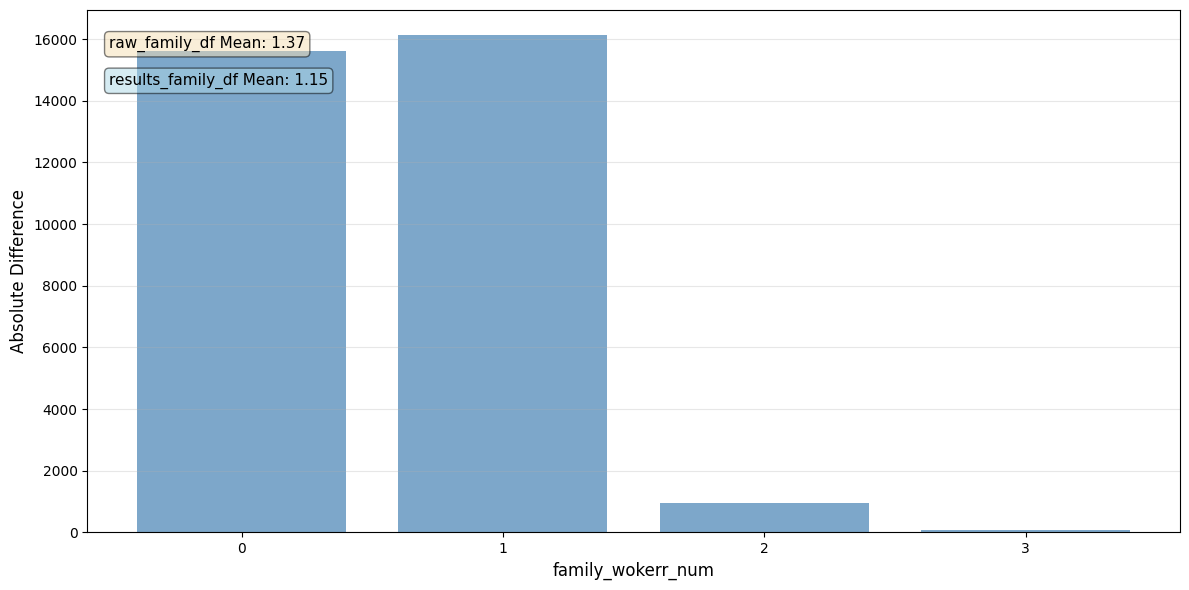

In [92]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 计算绝对差异
differences = abs(raw_family_df['family_家庭工作人口数'] - results_family_df['family_家庭工作人口数'])
print((differences==0).sum()/len(differences))
differences_stas = differences.value_counts()
# 计算两个数据源的均值
raw_mean = raw_family_df['family_家庭工作人口数'].mean()
results_mean = results_family_df['family_家庭工作人口数'].mean()

# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(differences_stas.index, differences_stas.values, alpha=0.7, color='steelblue')
plt.xticks(differences_stas.index)
plt.xlabel('family_wokerr_num', fontsize=12)
plt.ylabel('Absolute Difference', fontsize=12)
# plt.title('家庭成员数量绝对差异分布', fontsize=14, fontweight='bold')

# 在空白处添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

0.59686279296875


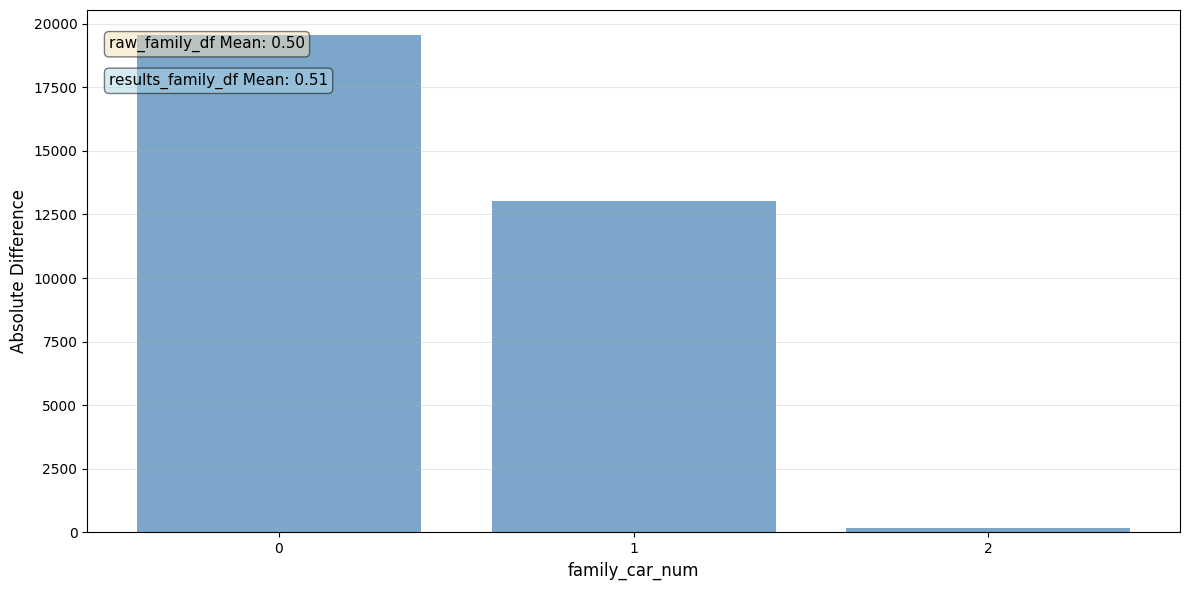

In [93]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 计算绝对差异
differences = abs(raw_family_df['family_机动车数量'] - results_family_df['family_机动车数量'])
print((differences==0).sum()/len(differences))
differences_stas = differences.value_counts()
# 计算两个数据源的均值
raw_mean = raw_family_df['family_机动车数量'].mean()
results_mean = results_family_df['family_机动车数量'].mean()

# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(differences_stas.index, differences_stas.values, alpha=0.7, color='steelblue')
plt.xticks(differences_stas.index)
plt.xlabel('family_car_num', fontsize=12)
plt.ylabel('Absolute Difference', fontsize=12)
# plt.title('家庭成员数量绝对差异分布', fontsize=14, fontweight='bold')

# 在空白处添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

0.539703369140625


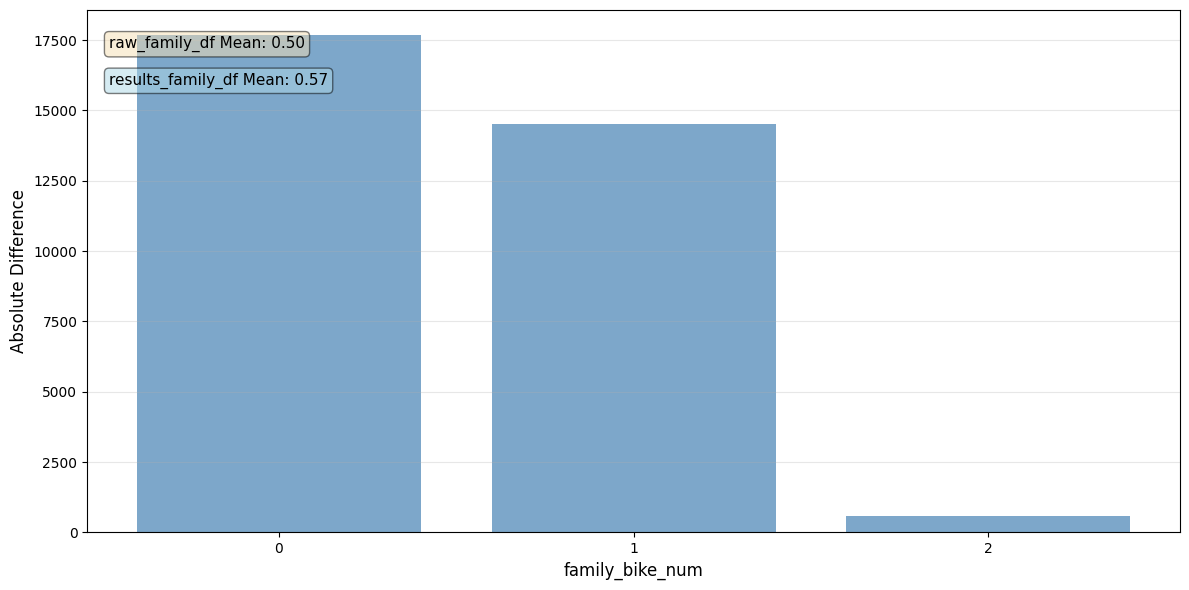

In [94]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 计算绝对差异
differences = abs(raw_family_df['family_脚踏自行车数量'] - results_family_df['family_脚踏自行车数量'])
print((differences==0).sum()/len(differences))
differences_stas = differences.value_counts()
# 计算两个数据源的均值
raw_mean = raw_family_df['family_脚踏自行车数量'].mean()
results_mean = results_family_df['family_脚踏自行车数量'].mean()

# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(differences_stas.index, differences_stas.values, alpha=0.7, color='steelblue')
plt.xticks(differences_stas.index)
plt.xlabel('family_bike_num', fontsize=12)
plt.ylabel('Absolute Difference', fontsize=12)
# plt.title('家庭成员数量绝对差异分布', fontsize=14, fontweight='bold')

# 在空白处添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

0.611846923828125


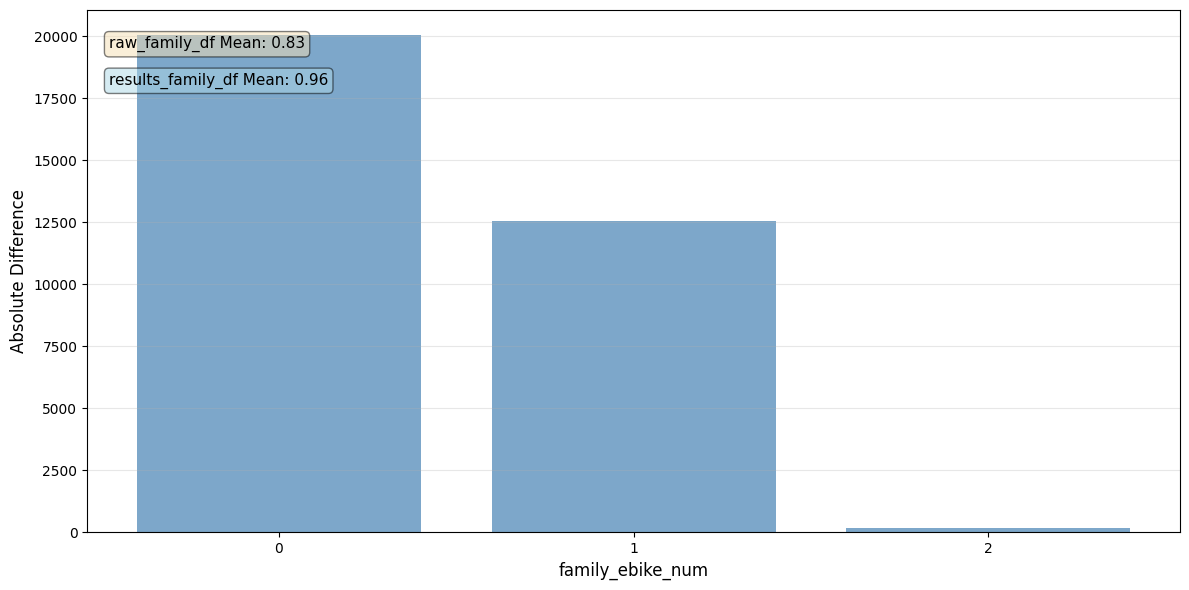

In [95]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 计算绝对差异
differences = abs(raw_family_df['family_电动自行车数量'] - results_family_df['family_电动自行车数量'])
print((differences==0).sum()/len(differences))
differences_stas = differences.value_counts()
# 计算两个数据源的均值
raw_mean = raw_family_df['family_电动自行车数量'].mean()
results_mean = results_family_df['family_电动自行车数量'].mean()

# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(differences_stas.index, differences_stas.values, alpha=0.7, color='steelblue')
plt.xticks(differences_stas.index)
plt.xlabel('family_ebike_num', fontsize=12)
plt.ylabel('Absolute Difference', fontsize=12)
# plt.title('家庭成员数量绝对差异分布', fontsize=14, fontweight='bold')

# 在空白处添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

0.99957275390625


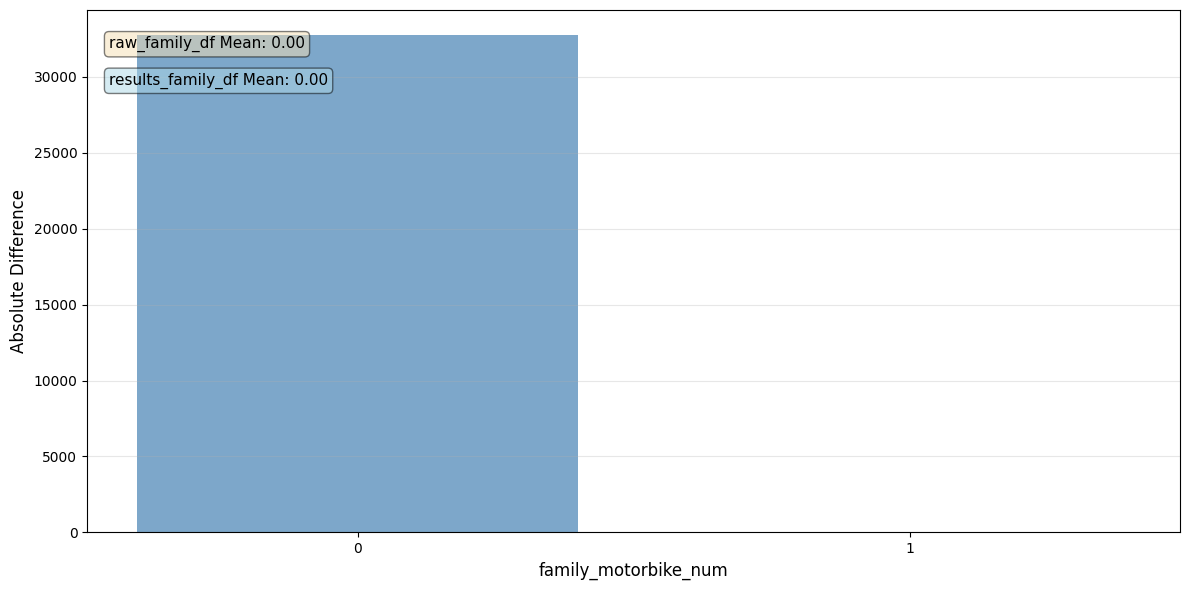

In [96]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 计算绝对差异
differences = abs(raw_family_df['family_摩托车数量'] - results_family_df['family_摩托车数量'])
print((differences==0).sum()/len(differences))
differences_stas = differences.value_counts()
# 计算两个数据源的均值
raw_mean = raw_family_df['family_摩托车数量'].mean()
results_mean = results_family_df['family_摩托车数量'].mean()

# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(differences_stas.index, differences_stas.values, alpha=0.7, color='steelblue')
plt.xticks(differences_stas.index)
plt.xlabel('family_motorbike_num', fontsize=12)
plt.ylabel('Absolute Difference', fontsize=12)
# plt.title('家庭成员数量绝对差异分布', fontsize=14, fontweight='bold')

# 在空白处添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

0.909881591796875


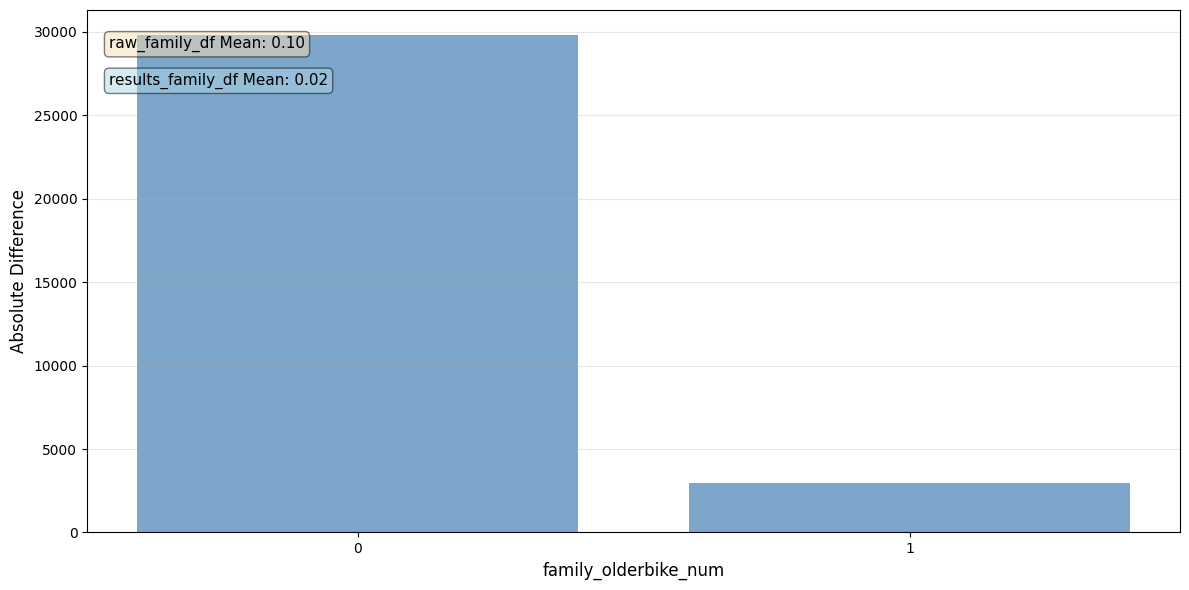

In [97]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 计算绝对差异
differences = abs(raw_family_df['family_老年代步车数量'] - results_family_df['family_老年代步车数量'])
print((differences==0).sum()/len(differences))
differences_stas = differences.value_counts()
# 计算两个数据源的均值
raw_mean = raw_family_df['family_老年代步车数量'].mean()
results_mean = results_family_df['family_老年代步车数量'].mean()

# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(differences_stas.index, differences_stas.values, alpha=0.7, color='steelblue')
plt.xticks(differences_stas.index)
plt.xlabel('family_olderbike_num', fontsize=12)
plt.ylabel('Absolute Difference', fontsize=12)
# plt.title('家庭成员数量绝对差异分布', fontsize=14, fontweight='bold')

# 在空白处添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [99]:
(raw_family_df['have_student'] == results_family_df['have_student']).sum()/len(raw_family_df)

0.8485107421875

In [100]:
(raw_family_df['income'] == results_family_df['income']).sum()/len(raw_family_df)

0.4019775390625

## 个人的

0.24430533375918237


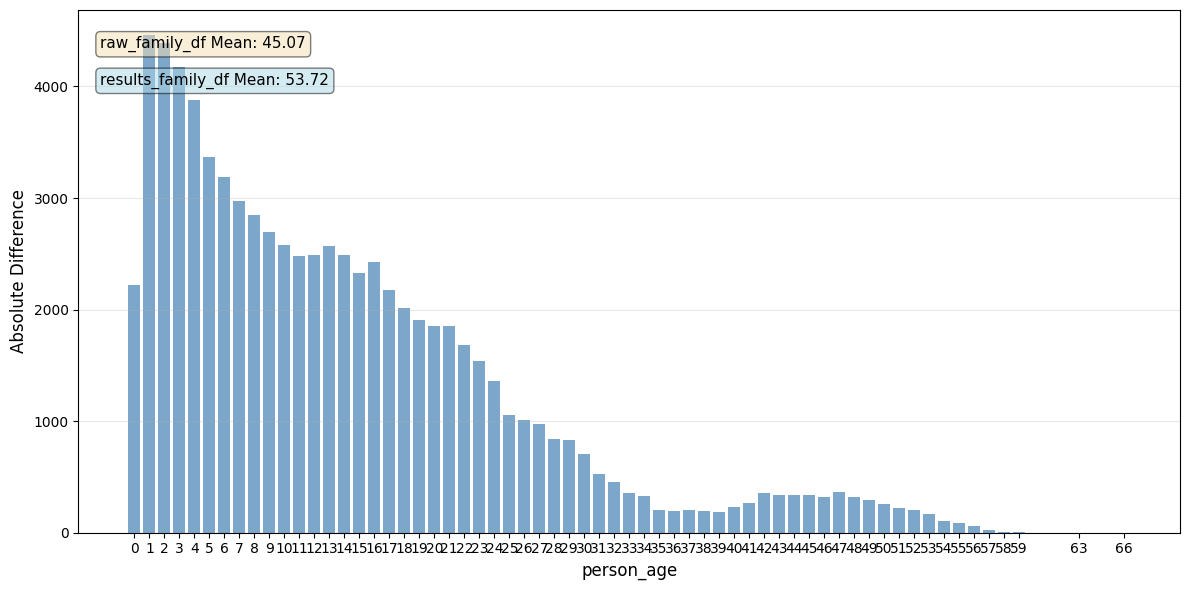

In [103]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 计算绝对差异
differences = abs(raw_person_df['age'] - results_person_df['age'])
print((differences<5).sum()/len(differences))
differences_stas = differences.value_counts()
# 计算两个数据源的均值
raw_mean = raw_person_df['age'].mean()
results_mean = results_person_df['age'].mean()

# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(differences_stas.index, differences_stas.values, alpha=0.7, color='steelblue')
plt.xticks(differences_stas.index)
plt.xlabel('person_age', fontsize=12)
plt.ylabel('Absolute Difference', fontsize=12)
# plt.title('家庭成员数量绝对差异分布', fontsize=14, fontweight='bold')

# 在空白处添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [106]:
(raw_person_df['gender'] == results_person_df['gender']).sum()/len(raw_person_df)

0.5997317151069945

In [107]:
(raw_person_df['license'] == results_person_df['license']).sum()/len(raw_person_df)

0.5819865857553498

In [108]:
(raw_person_df['relation'] == results_person_df['relation']).sum()/len(raw_person_df)

0.5337208559565634

In [109]:
(raw_person_df['education'] == results_person_df['education']).sum()/len(raw_person_df)

0.21441073139572023

In [110]:
(raw_person_df['occupation'] == results_person_df['occupation']).sum()/len(raw_person_df)

0.20162248482912806

## 精度比较2： 分布比较

### 家庭的

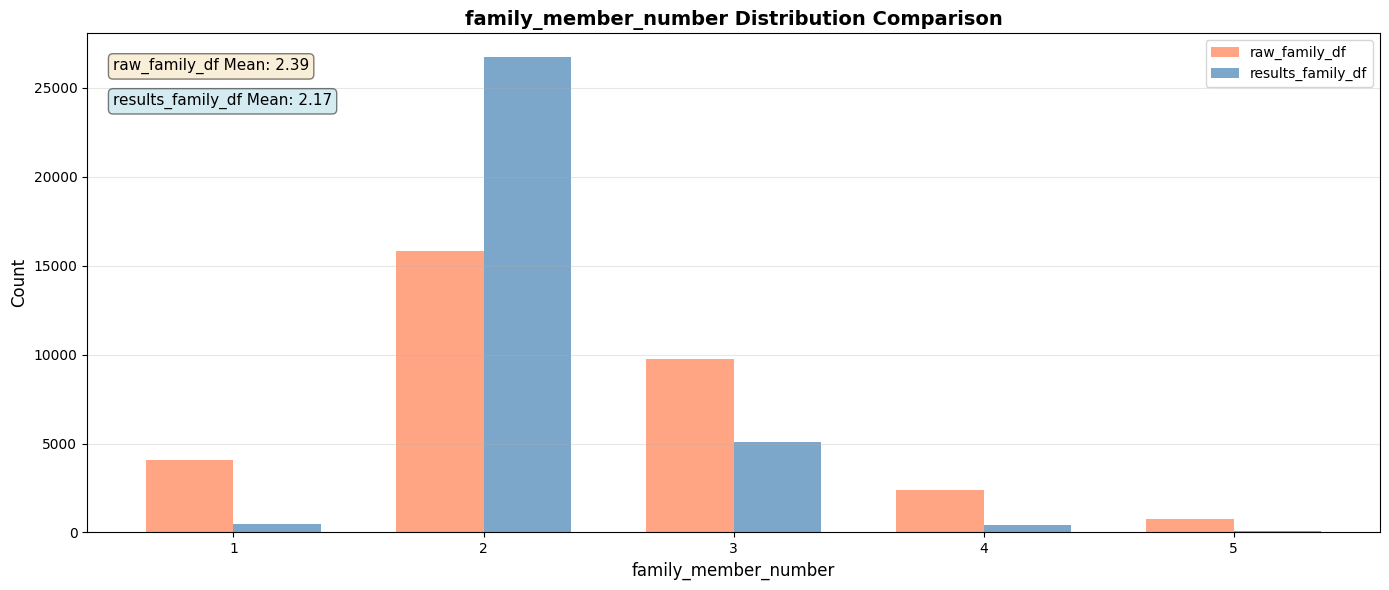

In [130]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_family_df['family_家庭成员数量'].value_counts().sort_index()
results_age_counts = results_family_df['family_家庭成员数量'].value_counts().sort_index()

# 计算均值
raw_mean = raw_family_df['family_家庭成员数量'].mean()
results_mean = results_family_df['family_家庭成员数量'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_family_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_family_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('family_member_number', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('family_member_number Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

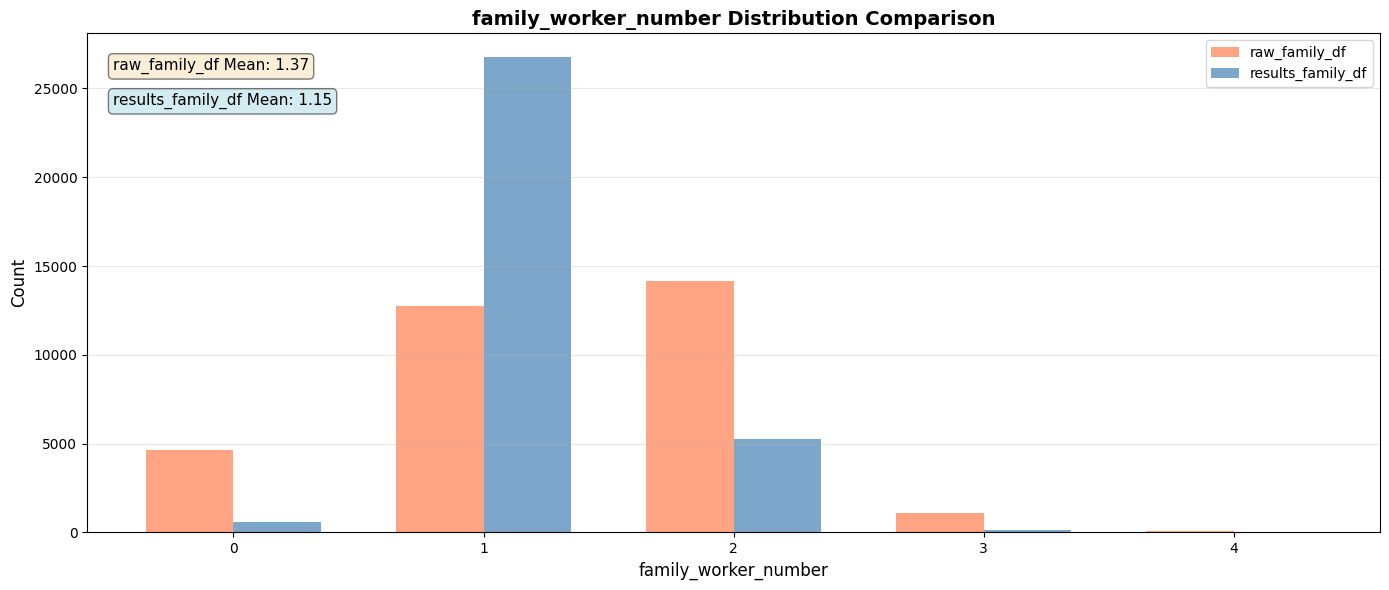

In [129]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_family_df['family_家庭工作人口数'].value_counts().sort_index()
results_age_counts = results_family_df['family_家庭工作人口数'].value_counts().sort_index()

# 计算均值
raw_mean = raw_family_df['family_家庭工作人口数'].mean()
results_mean = results_family_df['family_家庭工作人口数'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_family_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_family_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('family_worker_number', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('family_worker_number Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

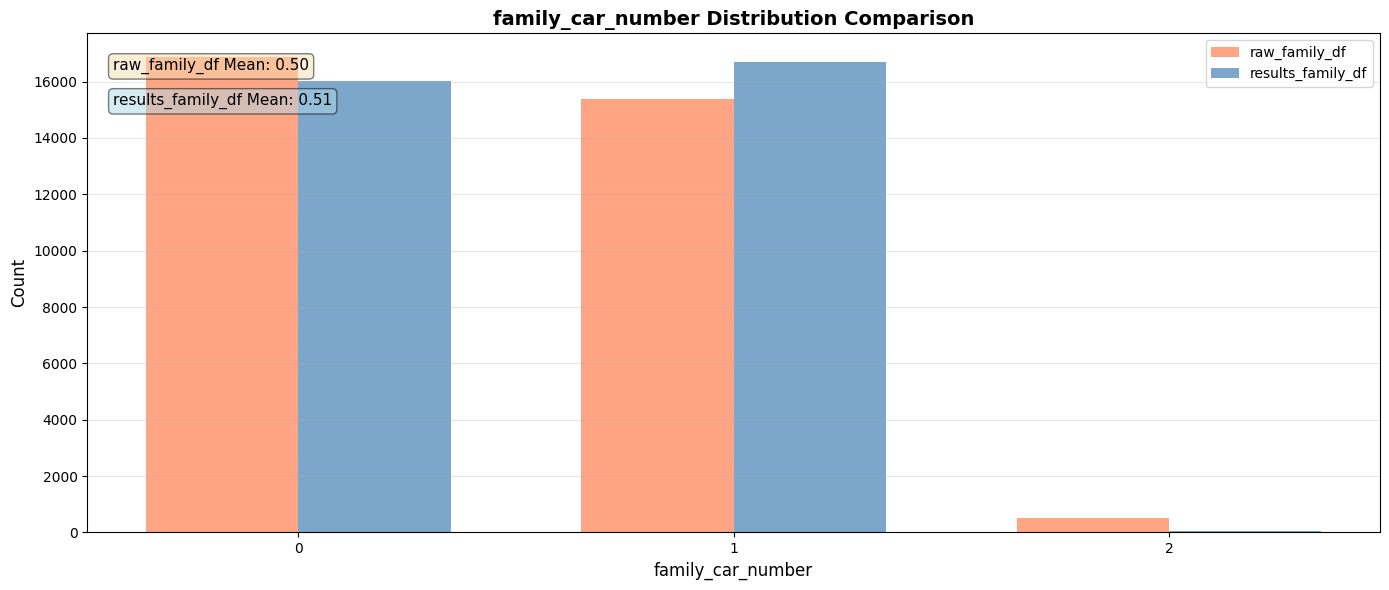

In [131]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_family_df['family_机动车数量'].value_counts().sort_index()
results_age_counts = results_family_df['family_机动车数量'].value_counts().sort_index()

# 计算均值
raw_mean = raw_family_df['family_机动车数量'].mean()
results_mean = results_family_df['family_机动车数量'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_family_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_family_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('family_car_number', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('family_car_number Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

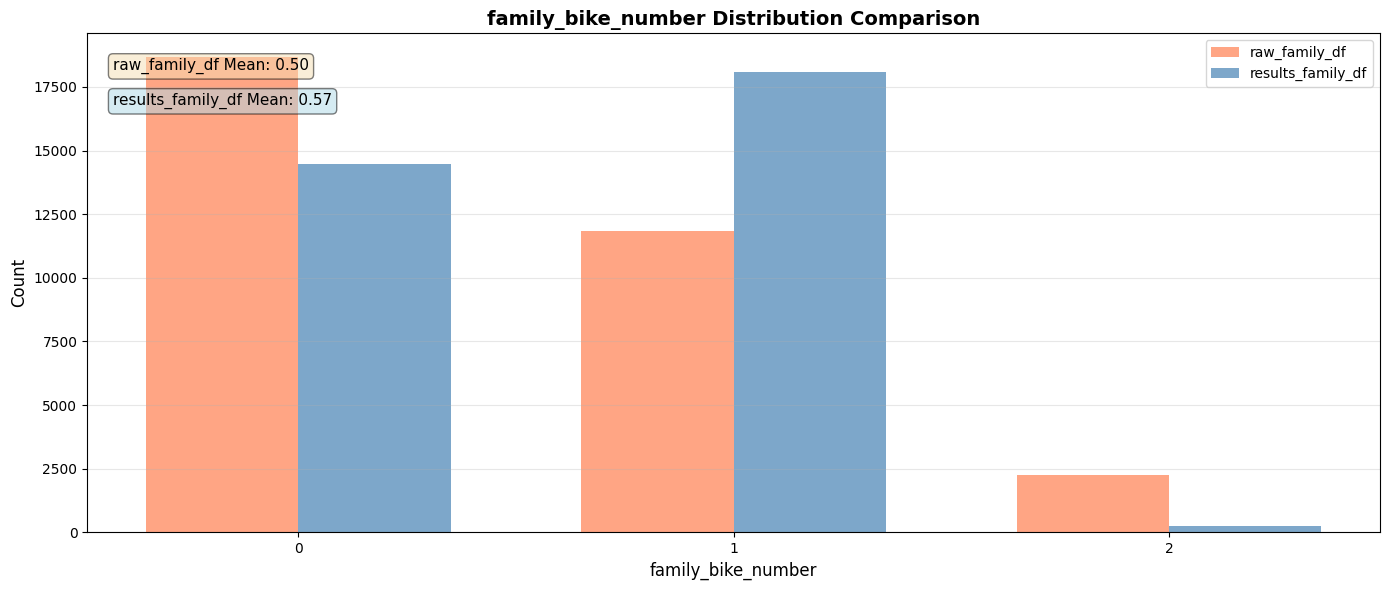

In [132]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_family_df['family_脚踏自行车数量'].value_counts().sort_index()
results_age_counts = results_family_df['family_脚踏自行车数量'].value_counts().sort_index()

# 计算均值
raw_mean = raw_family_df['family_脚踏自行车数量'].mean()
results_mean = results_family_df['family_脚踏自行车数量'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_family_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_family_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('family_bike_number', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('family_bike_number Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

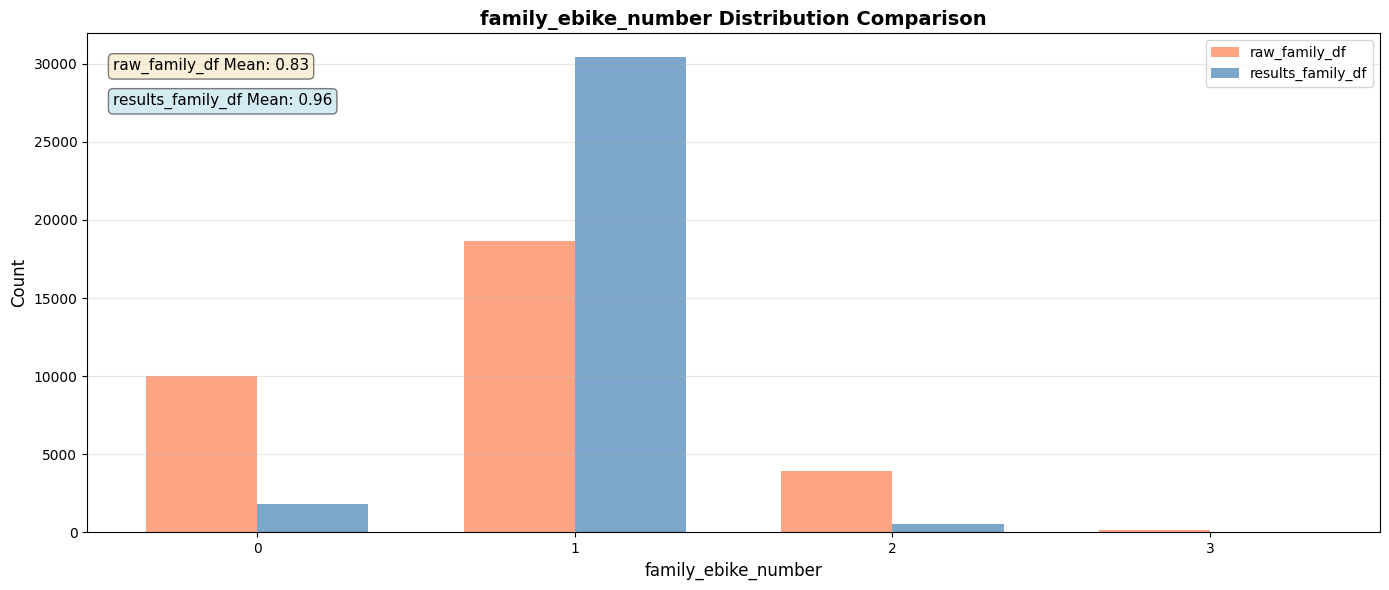

In [133]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_family_df['family_电动自行车数量'].value_counts().sort_index()
results_age_counts = results_family_df['family_电动自行车数量'].value_counts().sort_index()

# 计算均值
raw_mean = raw_family_df['family_电动自行车数量'].mean()
results_mean = results_family_df['family_电动自行车数量'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_family_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_family_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('family_ebike_number', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('family_ebike_number Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

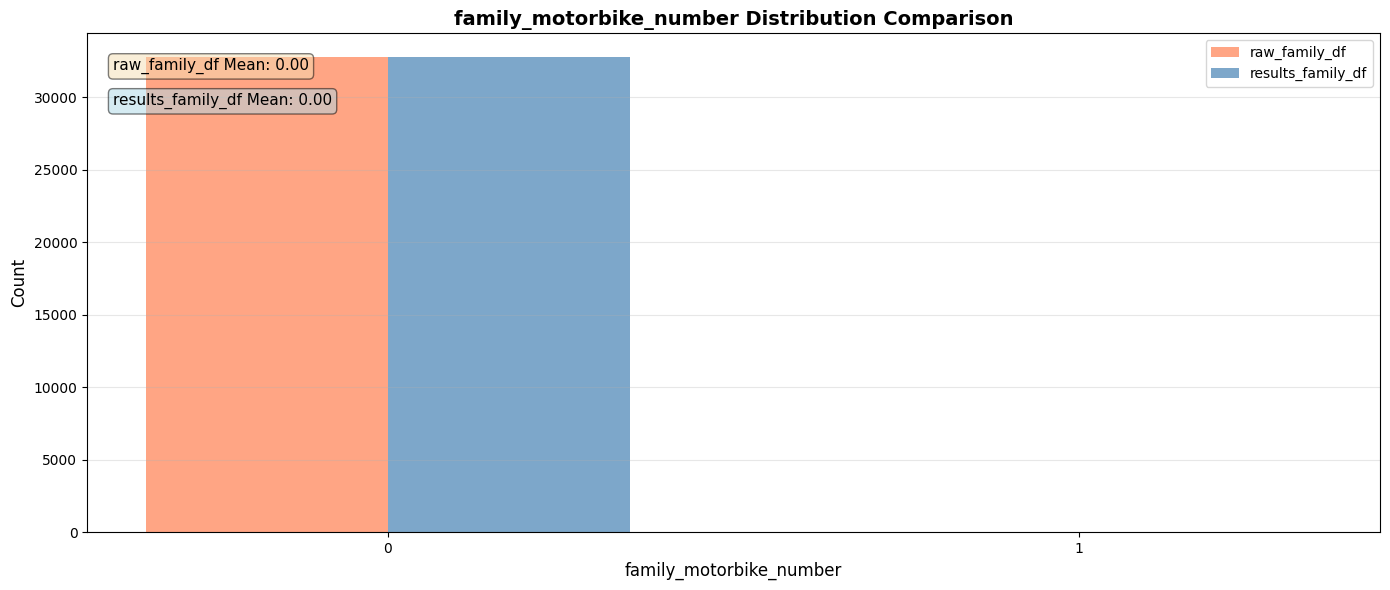

In [134]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_family_df['family_摩托车数量'].value_counts().sort_index()
results_age_counts = results_family_df['family_摩托车数量'].value_counts().sort_index()

# 计算均值
raw_mean = raw_family_df['family_摩托车数量'].mean()
results_mean = results_family_df['family_摩托车数量'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_family_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_family_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('family_motorbike_number', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('family_motorbike_number Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

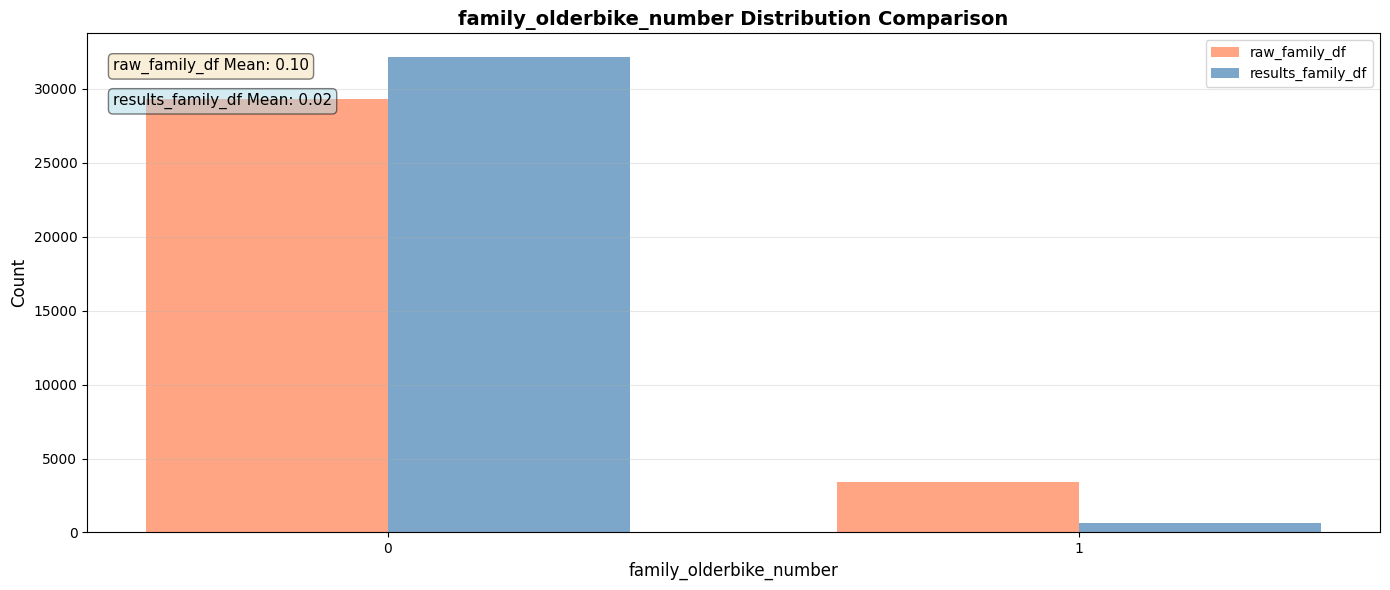

In [135]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_family_df['family_老年代步车数量'].value_counts().sort_index()
results_age_counts = results_family_df['family_老年代步车数量'].value_counts().sort_index()

# 计算均值
raw_mean = raw_family_df['family_老年代步车数量'].mean()
results_mean = results_family_df['family_老年代步车数量'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_family_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_family_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('family_olderbike_number', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('family_olderbike_number Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

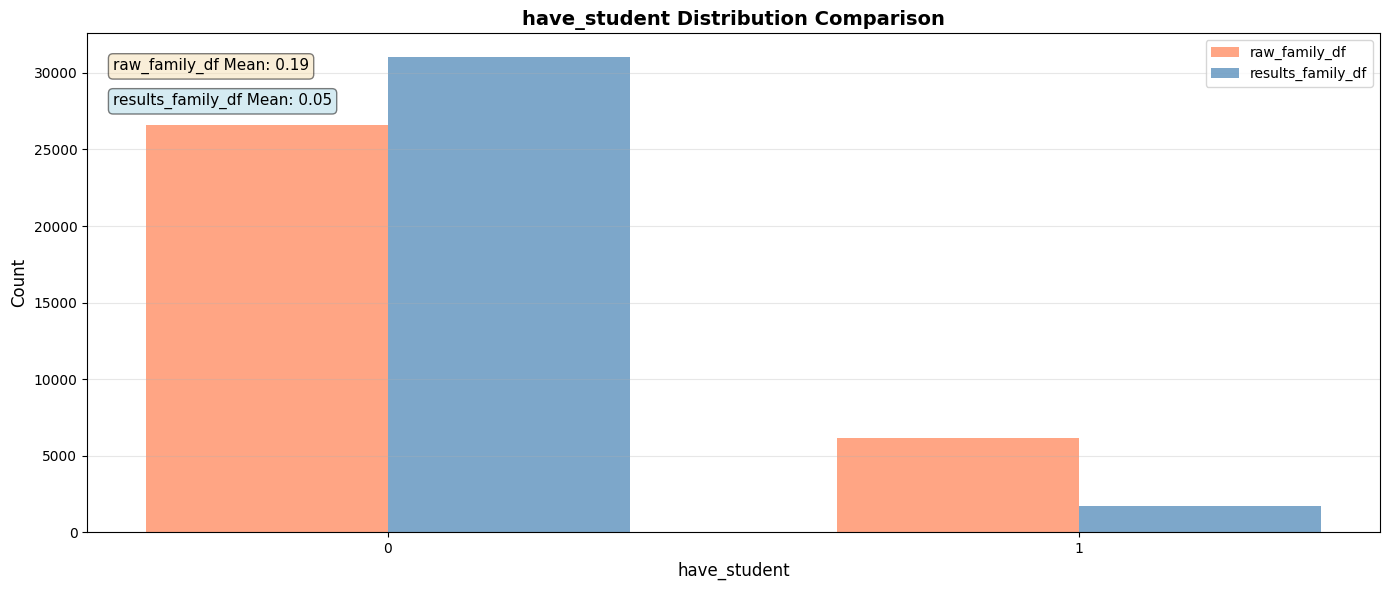

In [136]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_family_df['have_student'].value_counts().sort_index()
results_age_counts = results_family_df['have_student'].value_counts().sort_index()

# 计算均值
raw_mean = raw_family_df['have_student'].mean()
results_mean = results_family_df['have_student'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_family_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_family_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('have_student', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('have_student Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

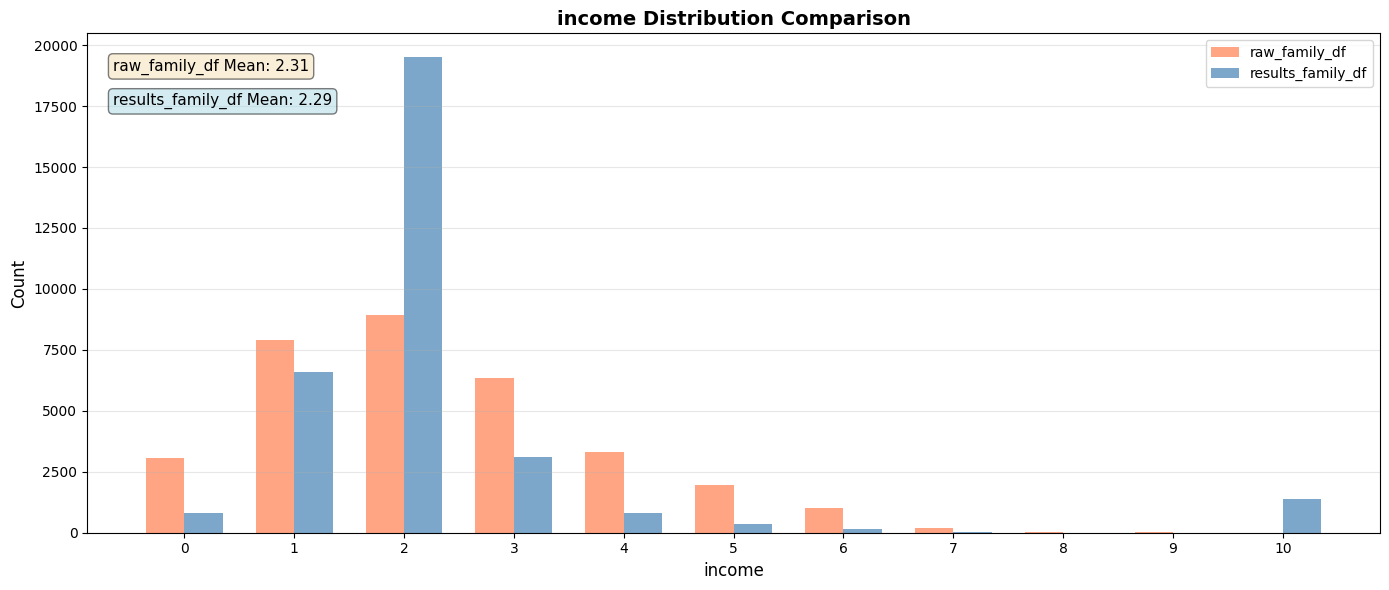

In [137]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_family_df['income'].value_counts().sort_index()
results_age_counts = results_family_df['income'].value_counts().sort_index()

# 计算均值
raw_mean = raw_family_df['income'].mean()
results_mean = results_family_df['income'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_family_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_family_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('income', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('income Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_family_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_family_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 个人的

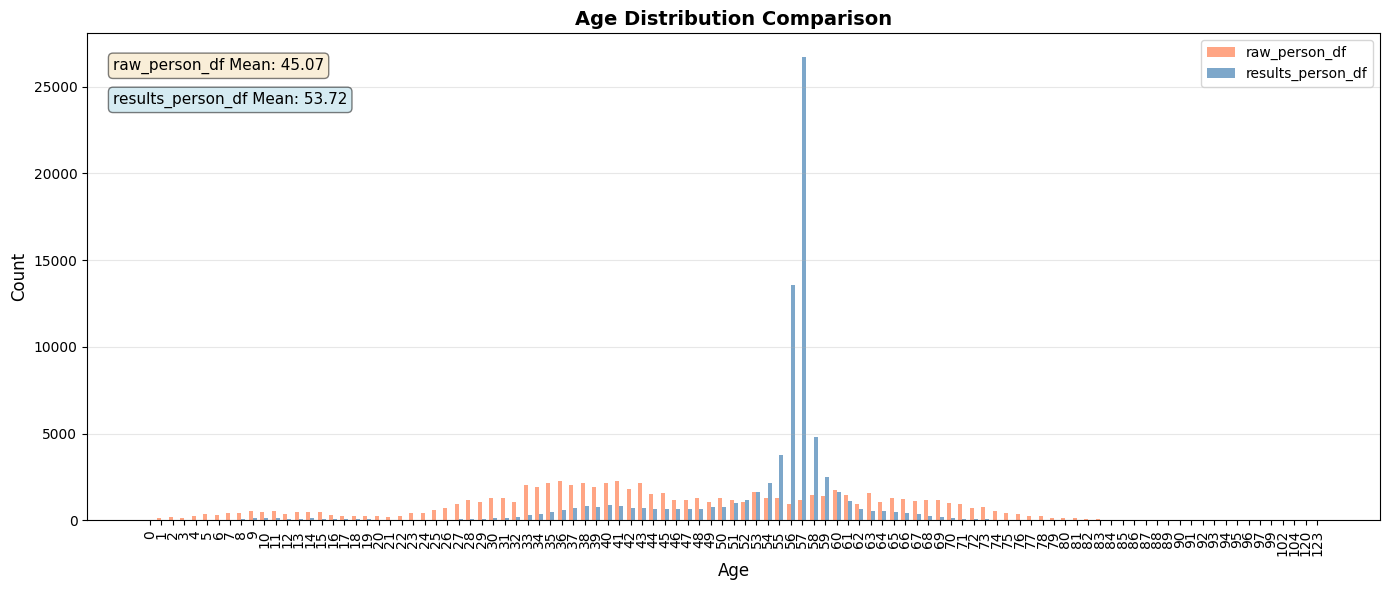

In [138]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_person_df['age'].value_counts().sort_index()
results_age_counts = results_person_df['age'].value_counts().sort_index()

# 计算均值
raw_mean = raw_person_df['age'].mean()
results_mean = results_person_df['age'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_person_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_person_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Age Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_person_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_person_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

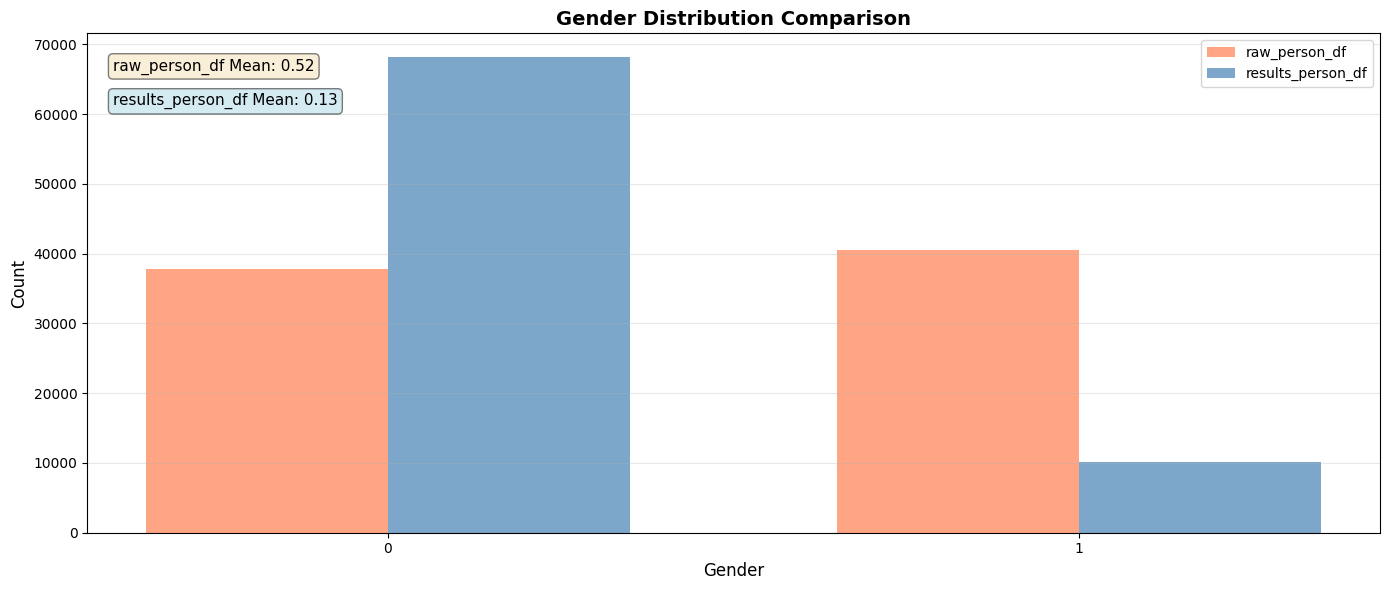

In [139]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_person_df['gender'].value_counts().sort_index()
results_age_counts = results_person_df['gender'].value_counts().sort_index()

# 计算均值
raw_mean = raw_person_df['gender'].mean()
results_mean = results_person_df['gender'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_person_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_person_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Gender Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_person_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_person_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

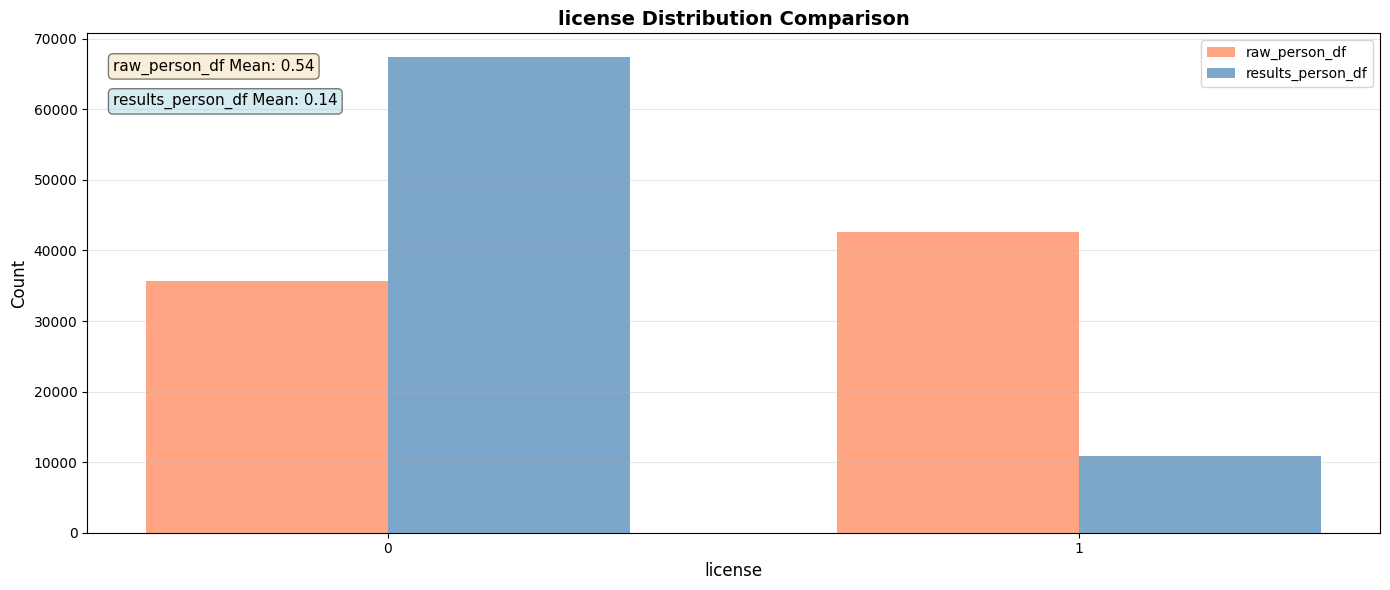

In [140]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_person_df['license'].value_counts().sort_index()
results_age_counts = results_person_df['license'].value_counts().sort_index()

# 计算均值
raw_mean = raw_person_df['license'].mean()
results_mean = results_person_df['license'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_person_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_person_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('license', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('license Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_person_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_person_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

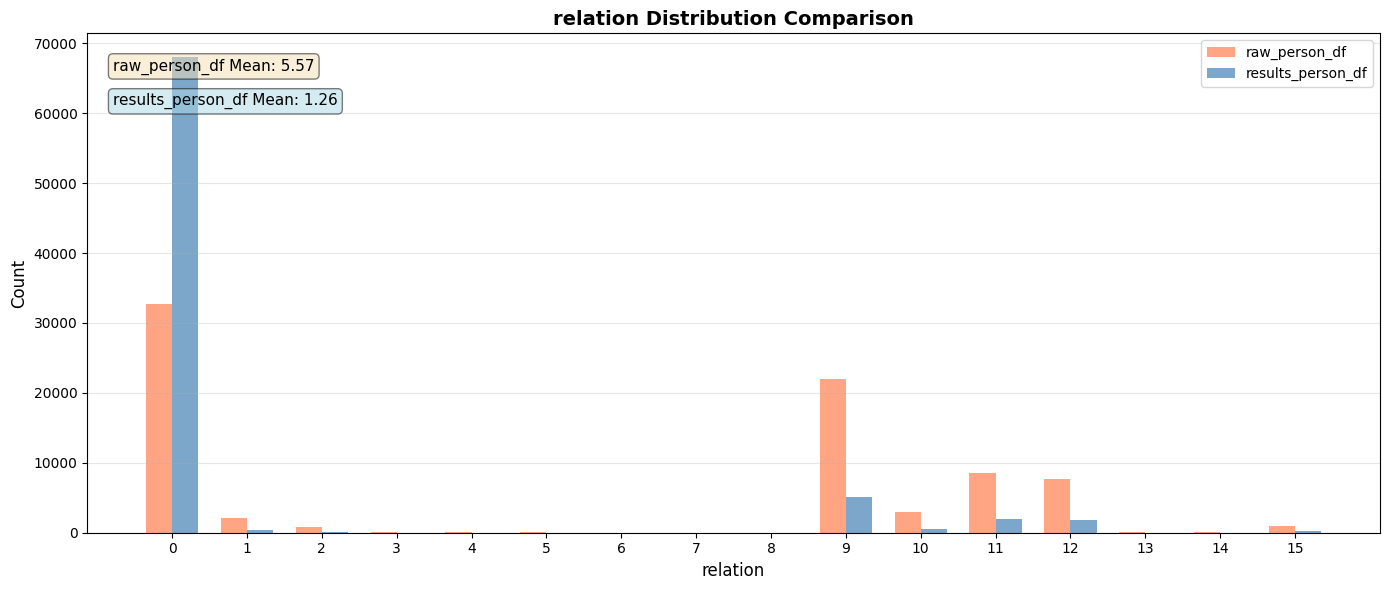

In [141]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_person_df['relation'].value_counts().sort_index()
results_age_counts = results_person_df['relation'].value_counts().sort_index()

# 计算均值
raw_mean = raw_person_df['relation'].mean()
results_mean = results_person_df['relation'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_person_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_person_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('relation', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('relation Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_person_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_person_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

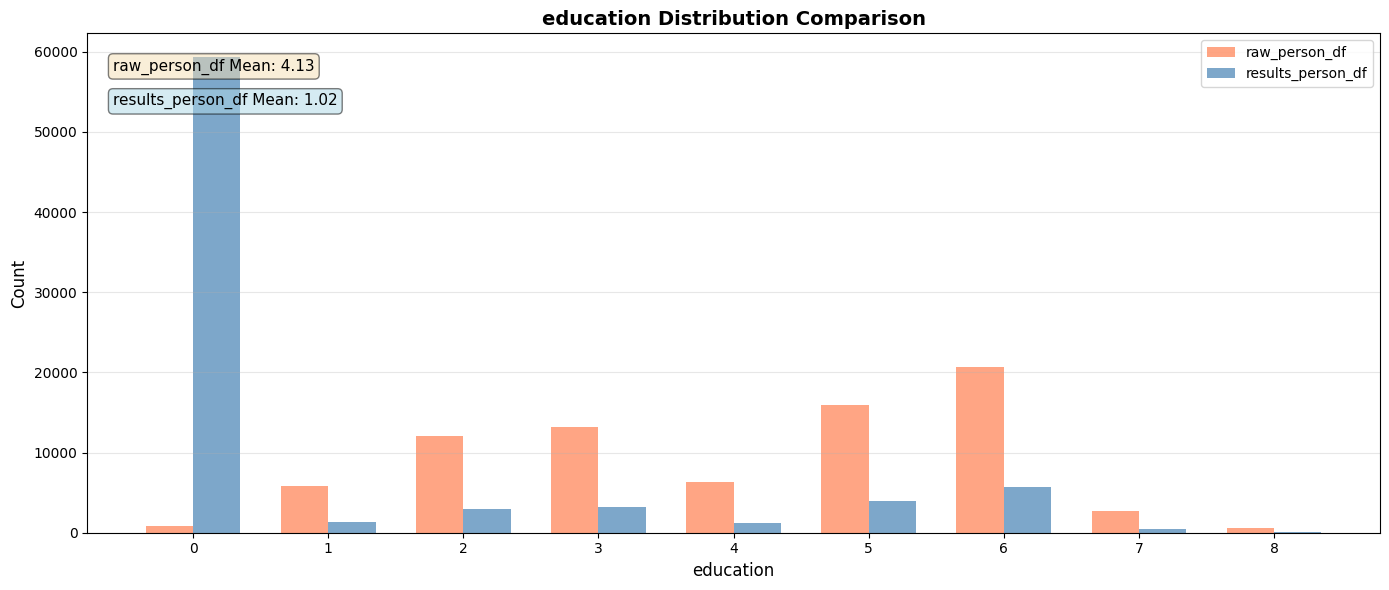

In [142]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_person_df['education'].value_counts().sort_index()
results_age_counts = results_person_df['education'].value_counts().sort_index()

# 计算均值
raw_mean = raw_person_df['education'].mean()
results_mean = results_person_df['education'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_person_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_person_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('education', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('education Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_person_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_person_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

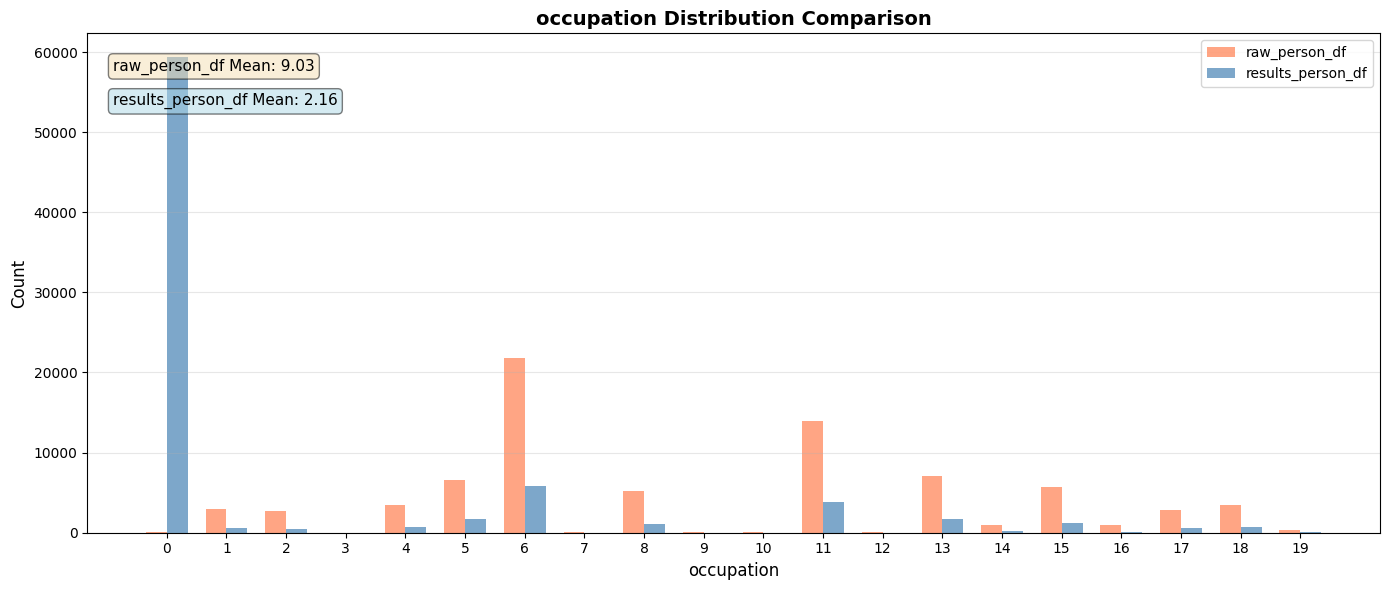

In [143]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取两个数据集的age分布
raw_age_counts = raw_person_df['occupation'].value_counts().sort_index()
results_age_counts = results_person_df['occupation'].value_counts().sort_index()

# 计算均值
raw_mean = raw_person_df['occupation'].mean()
results_mean = results_person_df['occupation'].mean()

# 创建一个合并的索引，确保包括两个数据集的所有年龄
all_ages = sorted(set(raw_age_counts.index) | set(results_age_counts.index))

# 准备绘图数据
raw_values = [raw_age_counts.get(age, 0) for age in all_ages]
results_values = [results_age_counts.get(age, 0) for age in all_ages]

# 创建柱状图
plt.figure(figsize=(14, 6))
x = np.arange(len(all_ages))
width = 0.35

plt.bar(x - width/2, raw_values, width, alpha=0.7, color='coral', label='raw_person_df')
plt.bar(x + width/2, results_values, width, alpha=0.7, color='steelblue', label='results_person_df')

plt.xticks(x, all_ages, rotation=90 if len(all_ages) > 30 else 0)
plt.xlabel('occupation', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('occupation Distribution Comparison', fontsize=14, fontweight='bold')
plt.legend()

# 添加均值标注
plt.text(0.02, 0.95, f'raw_person_df Mean: {raw_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.88, f'results_person_df Mean: {results_mean:.2f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()